In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install fairlearn

     |████████████████████████████████| 177 kB 4.3 MB/s 


In [ ]:
import seaborn
np.random.seed(20)

In [ ]:
from abc import ABCMeta, abstractmethod
from copy import Error, deepcopy
from functools import reduce
from random import sample
from sklearn.base import clone

import numpy as np
from numpy.lib.function_base import append
import sklearn
from sklearn.base import is_classifier, ClassifierMixin, is_regressor
from sklearn.ensemble import BaseEnsemble
from sklearn.ensemble._forest import BaseForest
# from sklearn.externals import six
import six
import sys
sys.modules['sklearn.externals.six'] = six
from sklearn.metrics import accuracy_score, confusion_matrix, max_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import BaseDecisionTree, DecisionTreeClassifier
from sklearn.tree._tree import DTYPE
from sklearn.utils.validation import has_fit_parameter, check_is_fitted, check_array, check_X_y, check_random_state

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.utils import check_random_state, _safe_indexing
from sklearn.utils.extmath import softmax
from sklearn.utils.extmath import stable_cumsum
from sklearn.metrics import accuracy_score, r2_score
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.validation import _check_sample_weight
from sklearn.utils.validation import has_fit_parameter
from sklearn.utils.validation import _num_samples

from fairlearn.metrics import *
import math

from fairlearn.postprocessing import ThresholdOptimizer


"""
  File "/localscratch/xuezhiyu/fairness/AdaFair/Ours.py", line 501, in fit
    return super(AdaFair2, self).fit(X, y, sample_weight)
  File "/localscratch/xuezhiyu/fairness/AdaFair/Ours.py", line 159, in fit
    sample_weight, alpha, error, fairness, balanced_error, cumulative_error, group_sample_weight = self._boost(
ValueError: not enough values to unpack (expected 7, got 3)
"""

class BaseWeightBoosting(six.with_metaclass(ABCMeta, BaseEnsemble)):
    """Base class for AdaBoost estimators.

    Warning: This class should not be used directly. Use derived classes
    instead.
    """

    @abstractmethod
    def __init__(self,
                 base_estimator=None,
                 n_estimators=50,
                 estimator_params=tuple(),
                 learning_rate=1.,
                 random_state=None,modify_d=True,group_acc=False,norm_each_group=True):

        super(BaseWeightBoosting, self).__init__(
            base_estimator=base_estimator,
            n_estimators=n_estimators,
            estimator_params=estimator_params)

        self.learning_rate = learning_rate
        self.random_state = random_state
        self.modify_d = modify_d

        self.group_acc = group_acc
        self.init_sample_weight = 0
        self.norm_each_group = norm_each_group

    def fit(self, X, y, sample_weight=None):
        
        """Build a boosted classifier/regressor from the training set (X, y).

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape = [n_samples, n_features]
            The training input samples. Sparse matrix can be CSC, CSR, COO,
            DOK, or LIL. COO, DOK, and LIL are converted to CSR. The dtype is
            forced to DTYPE from tree._tree if the base classifier of this
            ensemble weighted boosting classifier is a tree or forest.

        y : array-like of shape = [n_samples]
            The target values (class labels in classification, real numbers in
            regression).

        sample_weight : array-like of shape = [n_samples], optional
            Sample weights. If None, the sample weights are initialized to
            1 / n_samples.

        Returns
        -------
        self : object
            Returns self.
        """
        # Check parameters
        self.weight_list = []
        if self.learning_rate <= 0:
            raise ValueError("learning_rate must be greater than zero")

        if (self.base_estimator is None or
                isinstance(self.base_estimator, (BaseDecisionTree,
                                                 BaseForest))):
            dtype = DTYPE
            accept_sparse = 'csc'
        else:
            dtype = None
            accept_sparse = ['csr', 'csc']

        X, y = check_X_y(X, y, accept_sparse=accept_sparse, dtype=dtype,
                         y_numeric=is_regressor(self))

        self.X_valid = self.y_valid = None
        if self.use_validation:
            X, self.X_valid, y, self.y_valid = train_test_split(X, y, test_size = 0.3, shuffle=True, stratify=y)


        if sample_weight is None:
            # Initialize weights to 1 / n_samples
            sample_weight = np.empty(X.shape[0], dtype=np.float64)
            sample_weight[:] = 1. / X.shape[0]
        else:
            sample_weight = check_array(sample_weight, ensure_2d=False)
            # Normalize existing weights
            sample_weight = sample_weight / sample_weight.sum(dtype=np.float64)

            # Check that the sample weights sum is positive
            if sample_weight.sum() <= 0:
                raise ValueError(
                    "Attempting to fit with a non-positive "
                    "weighted number of samples.")


        self.init_sample_weight = sample_weight

        # Check parameters
        self._validate_estimator()

        # Clear any previous fit results
        self.estimators_ = []

        self.estimator_alphas_ = np.zeros(self.n_estimators, dtype=np.float64)
        self.estimator_fairness_ = np.ones(self.n_estimators, dtype=np.float64)

        random_state = check_random_state(self.random_state)
        # if self.debug:
        #     pos, neg, dp, fp, dn, fn = self.calculate_weights(X, y, sample_weight)
        #     print  ("iteration, alpha , positives , negatives , dp , fp , dn , fn")

        old_weights_sum = np.sum(sample_weight)
        self.predictions_array = np.zeros([X.shape[0], 2])
        old_factor = 1
        if self.use_validation:
            self.predictions_array_valid = np.zeros([self.X_valid.shape[0], 2])

        if self.debug:
            self.predictions_array_test = np.zeros([self.X_test.shape[0], 2])

        # if self.debug:
        #     self.weight_list.append(
        #         'init' + "," + str(0) + "," + str(pos) + ", " + str(neg) + ", " + str(dp) + ", " + str(
        #             fp) + ", " + str(dn) + ", " + str(fn))


        sample_weight_p_pos, sample_weight_p_neg, sample_weight_np_pos, sample_weight_np_neg = self.initialization_group(sample_weight,X,y)
    
        for iboost in range(self.n_estimators):
            # Boosting step
            # print(iboost)
            # print(sample_weight)
            # print(np.sum(sample_weight))
            sample_weight_p_pos, sample_weight_p_neg, sample_weight_np_pos, sample_weight_np_neg, alpha, estimator_error = self._boost(
                     iboost, X, y, 
                    sample_weight_p_pos, sample_weight_p_neg, sample_weight_np_pos, sample_weight_np_neg, 
                     random_state)

            # Early termination
            if sample_weight is None:
                break
            if alpha is None:
                break

            # Stop if error is zero
            if estimator_error == 0.5:
                break
            if estimator_error <= 0:
                break
            if self.norm_each_group:
                sample_weight_p_pos = sample_weight_p_pos/np.sum(sample_weight_p_pos)
                sample_weight_p_neg = sample_weight_p_neg/np.sum(sample_weight_p_neg)
                sample_weight_np_pos = sample_weight_np_pos/np.sum(sample_weight_np_pos)
                sample_weight_np_neg = sample_weight_np_neg/np.sum(sample_weight_np_neg)

            #multiplier = old_weights_sum / new_sample_weight
            # Stop if the sum of sample weights has become non-positive
            
            if np.sum(sample_weight) <= 0:
                break

        if True in self.is_constrain_list:
            print('Puring')
            is_constrain_list = list(reversed(self.is_constrain_list))
            # is_constrain_list = self.is_constrain_list[]
            idx = is_constrain_list.index(True)
            idx = len(self.is_constrain_list) - idx
            print(idx)
            print(self.is_constrain_list[:idx][-1])
            print(self.fair_error_trace[:idx][-1])
            print(self.is_constrain_list)
            print('------------')
            self.estimators_ = self.estimators_[:idx]
            self.estimator_alphas_ = self.estimator_alphas_[:idx]
        else:
            print('Retrain model')
            self.random_state = self.random_state + 1
            self.fit(X,y)
            

            


        """
        best_theta = self.tuning_learners.index(min(self.tuning_learners))
        self.theta = best_theta + 1
        self.estimators_ = self.estimators_[:self.theta  ]
        self.estimator_alphas_ = self.estimator_alphas_[:self.theta]
        """
        # if self.debug:
        #     self.get_confidence_scores(X)

        return self


    def get_weights_over_iterations(self,):
        return self.weight_list[self.theta]

    def get_confidence_scores(self, X):
        self.conf_scores = self.decision_function(X)


    def get_initial_weights(self):
        return self.weight_list[0]

    def get_weights(self,):
        return [self.W_pos, self.W_neg, self.W_dp, self.W_fp, self.W_dn, self.W_fn]
    
    @abstractmethod
    def initialization_group(self,sample_weight,X,y):
        pass
    
    @abstractmethod
    def _boost(self, iboost, X, y, sample_weight_p_pos, sample_weight_p_neg, sample_weight_np_pos, sample_weight_np_neg, random_state):
        """Implement a single boost.

        Warning: This method needs to be overridden by subclasses.

        Parameters
        ----------
        iboost : int
            The index of the current boost iteration.

        X : {array-like, sparse matrix} of shape = [n_samples, n_features]
            The training input samples. Sparse matrix can be CSC, CSR, COO,
            DOK, or LIL. COO, DOK, and LIL are converted to CSR.

        y : array-like of shape = [n_samples]
            The target values (class labels).

        sample_weight : array-like of shape = [n_samples]
            The current sample weights.

        random_state : numpy.RandomState
            The current random number generator

        Returns
        -------
        sample_weight : array-like of shape = [n_samples] or None
            The reweighted sample weights.
            If None then boosting has terminated early.

        estimator_weight : float
            The weight for the current boost.
            If None then boosting has terminated early.

        error : float
            The classification error for the current boost.
            If None then boosting has terminated early.
        """
        pass

    def staged_score(self, X, y, sample_weight=None):
        """Return staged scores for X, y.

        This generator method yields the ensemble score after each iteration of
        boosting and therefore allows monitoring, such as to determine the
        score on a test set after each boost.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape = [n_samples, n_features]
            The training input samples. Sparse matrix can be CSC, CSR, COO,
            DOK, or LIL. DOK and LIL are converted to CSR.

        y : array-like, shape = [n_samples]
            Labels for X.

        sample_weight : array-like, shape = [n_samples], optional
            Sample weights.

        Returns
        -------
        z : float
        """
        for y_pred in self.staged_predict(X):
            if is_classifier(self):
                yield accuracy_score(y, y_pred, sample_weight=sample_weight)
            else:
                yield r2_score(y, y_pred, sample_weight=sample_weight)

    @property
    def feature_importances_(self):
        """Return the feature importances (the higher, the more important the
           feature).

        Returns
        -------
        feature_importances_ : array, shape = [n_features]
        """
        if self.estimators_ is None or len(self.estimators_) == 0:
            raise ValueError("Estimator not fitted, "
                             "call `fit` before `feature_importances_`.")

        try:
            norm = self.estimator_alphas_.sum()
            return (sum(weight * clf.feature_importances_ for weight, clf
                        in zip(self.estimator_alphas_, self.estimators_))
                    / norm)

        except AttributeError:
            raise AttributeError(
                "Unable to compute feature importances "
                "since base_estimator does not have a "
                "feature_importances_ attribute")

    def _validate_X_predict(self, X):
        """Ensure that X is in the proper format"""
        if (self.base_estimator is None or
                isinstance(self.base_estimator,
                           (BaseDecisionTree, BaseForest))):
            X = check_array(X, accept_sparse='csr', dtype=DTYPE)

        else:
            X = check_array(X, accept_sparse=['csr', 'csc', 'coo'])

        return X

def _samme_proba(estimator, n_classes, X):
    """Calculate algorithm 4, step 2, equation c) of Zhu et al [1].

    References
    ----------
    .. [1] J. Zhu, H. Zou, S. Rosset, T. Hastie, "Multi-class AdaBoost", 2009.

    """
    proba = estimator.predict_proba(X)

    # Displace zero probabilities so the log is defined.
    # Also fix negative elements which may occur with
    # negative sample weights.
    proba[proba < np.finfo(proba.dtype).eps] = np.finfo(proba.dtype).eps
    log_proba = np.log(proba)

    return (n_classes - 1) * (log_proba - (1. / n_classes)
                              * log_proba.sum(axis=1)[:, np.newaxis])

class Group_AdaBoost(BaseWeightBoosting, ClassifierMixin):
    """An AdaBoost classifier.

    An AdaBoost [1] classifier is a meta-estimator that begins by fitting a
    classifier on the original dataset and then fits additional copies of the
    classifier on the same dataset but where the weights of incorrectly
    classified instances are adjusted such that subsequent classifiers focus
    more on difficult cases.

    This class implements the algorithm known as AdaBoost-SAMME [2].

    Read more in the :ref:`User Guide <adaboost>`.

    Parameters
    ----------
    base_estimator : object, optional (default=DecisionTreeClassifier)
        The base estimator from which the boosted ensemble is built.
        Support for sample weighting is required, as well as proper `classes_`
        and `n_classes_` attributes.

    n_estimators : integer, optional (default=50)
        The maximum number of estimators at which boosting is terminated.
        In case of perfect fit, the learning procedure is stopped early.

    learning_rate : float, optional (default=1.)
        Learning rate shrinks the contribution of each classifier by
        ``learning_rate``. There is a trade-off between ``learning_rate`` and
        ``n_estimators``.

    algorithm : {'SAMME', 'SAMME.R'}, optional (default='SAMME.R')
        If 'SAMME.R' then use the SAMME.R real boosting algorithm.
        ``base_estimator`` must support calculation of class probabilities.
        If 'SAMME' then use the SAMME discrete boosting algorithm.
        The SAMME.R algorithm typically converges faster than SAMME,
        achieving a lower test error with fewer boosting iterations.

    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.

    Attributes
    ----------
    estimators_ : list of classifiers
        The collection of fitted sub-estimators.

    classes_ : array of shape = [n_classes]
        The classes labels.

    n_classes_ : int
        The number of classes.

    estimator_weights_ : array of floats
        Weights for each estimator in the boosted ensemble.

    estimator_errors_ : array of floats
        Classification error for each estimator in the boosted
        ensemble.

    feature_importances_ : array of shape = [n_features]
        The feature importances if supported by the ``base_estimator``.

    See also
    --------
    AdaBoostRegressor, GradientBoostingClassifier, DecisionTreeClassifier

    References
    ----------
    .. [1] Y. Freund, R. Schapire, "A Decision-Theoretic Generalization of
           on-Line Learning and an Application to Boosting", 1995.

    .. [2] J. Zhu, H. Zou, S. Rosset, T. Hastie, "Multi-class AdaBoost", 2009.

    """
    def __init__(self,
                base_estimator=None,
                n_estimators=50,
                learning_rate=1.,
                cumul=True,
                algorithm='SAMME',
                random_state=None,
                saIndex=None,saValue=None,
                debug=False, CSB="CSB2",
                X_test=None, y_test=None, c = 1, use_validation=False, proba=False
                ,modify_alpha=True, modify_d=False, alpha_restri=False, imbalance=False, fairness_factor=0, acc_iter_ratio=0, group_acc=False,sample_weight_store=False,
                acc_stop=False,check_point=False, use_alpha_acc=False, balance_monitor=False,depth=1,boost_metric='Acc',adaptive_weight=False,
                tau_weight=[0.25,0.25,0.25,0.25],norm_each_group=False,boosting_type='ad_hoc',adaptive_beta=False,k=0.1,
                X_val=None,y_val=None,calibrate_base_learner=False,max_error_thres=0.45,calibrate_base_learner_beta=False,adaptive_lr=False,
                mask_sen_attr=False,fair_constrain=1,reduce_factor=0.6):

        super(Group_AdaBoost, self).__init__(
            base_estimator=base_estimator,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            random_state=random_state,
            modify_d=modify_d,
            group_acc = group_acc,
            norm_each_group = norm_each_group)

        self.cost_protected_positive = 1
        self.cost_non_protected_positive = 1
        self.cumul = cumul
        self.cost_protected_negative = 1
        self.cost_non_protected_negative = 1

        self.c = c
        self.saIndex = saIndex
        self.saValue = saValue
        self.algorithm = algorithm

        self.use_validation = use_validation
        self.use_proba = proba
        self.costs = []

        self.debug = debug
        self.csb = CSB
        self.X_test = X_test
        self.y_test = y_test

        self.alpha_restri = alpha_restri

        self.modify_alpha = modify_alpha
        self.modify_d = modify_d

        self.imbalance = imbalance
        self.fairness_factor = fairness_factor

        self.acc_iter = int(n_estimators*acc_iter_ratio)

        self.init_sample_weight = 0

        self.acc_stop = acc_stop

        self.sample_weight_store = sample_weight_store
        if sample_weight_store == True:
            self.sample_weight_data = [] 
            self.color = []

        self.use_alpha_acc = use_alpha_acc

        self.check_point = check_point
        if self.check_point is True:
            self.check_point_store = {'alpha':[],'alpha_acc':[],'performance_error':[],'fairness_error':[], 'all_error':[]
            ,'b_acc':[],'eq_od':[]}

        self.balance_monitor = balance_monitor

        self.depth = depth

        self.boost_metric = boost_metric

        self.adaptive_weight = adaptive_weight

        self.tau_weight = tau_weight

        self.boosting_type = boosting_type

        self.adaptive_beta = adaptive_beta

        self.k = k

        self.X_val = X_val
        self.y_val = y_val

        self.calibrate_base_learner = calibrate_base_learner
        self.thres_list = []

        self.max_error_thres = max_error_thres

        self.pas_error = [0.25,0.25,0.25,0.25]

        self.calibrate_base_learner_beta = calibrate_base_learner_beta

        self.adaptive_lr = adaptive_lr

        self.fair_constrain = fair_constrain

        self.reduce_factor = reduce_factor

        self.is_constrain_list = []

        self.fair_error_trace = []

        # self.mask_sen_attr = mask_sen_attr

    def fit(self, X, y, sample_weight=None):
        """
        Build a boosted classifier from the training set (X, y).

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape = [n_samples, n_features]
            The training input samples. Sparse matrix can be CSC, CSR, COO,
            DOK, or LIL. DOK and LIL are converted to CSR.

        y : array-like of shape = [n_samples]
            The target values (class labels).

        sample_weight : array-like of shape = [n_samples], optional
            Sample weights. If None, the sample weights are initialized to
            ``1 / n_samples``.

        Returns
        -------
        self : object
            Returns self.
        """
        # Check that algorithm is supported
        if self.algorithm not in ('SAMME', 'SAMME.R'):
            raise ValueError("algorithm %s is not supported" % self.algorithm)

        # Fit
        return super(Group_AdaBoost, self).fit(X, y, sample_weight)

    def _validate_estimator(self):
        """Check the estimator and set the base_estimator_ attribute."""
        super(Group_AdaBoost, self)._validate_estimator(
            default=DecisionTreeClassifier(max_depth=1))

        #  SAMME-R requires predict_proba-enabled base estimators
        if self.algorithm == 'SAMME.R':
            if not hasattr(self.base_estimator_, 'predict_proba'):
                raise TypeError(
                    "AccumFairAdaCost with algorithm='SAMME.R' requires "
                    "that the weak learner supports the calculation of class "
                    "probabilities with a predict_proba method.\n"
                    "Please change the base estimator or set "
                    "algorithm='SAMME' instead.")
        if not has_fit_parameter(self.base_estimator_, "sample_weight"):
            raise ValueError("%s doesn't support sample_weight."
                             % self.base_estimator_.__class__.__name__)
                             

    def _boost(self, iboost, X, y, sample_weight_p_pos, sample_weight_p_neg, sample_weight_np_pos, sample_weight_np_neg, random_state):
        return self._boost_discrete(iboost, X, y, sample_weight_p_pos, sample_weight_p_neg, sample_weight_np_pos, sample_weight_np_neg, random_state)

    def calculate_fairness(self, data, labels, predictions):

        tp_protected = 0.
        tn_protected = 0.
        fp_protected = 0.
        fn_protected = 0.

        tp_non_protected = 0.
        tn_non_protected = 0.
        fp_non_protected = 0.
        fn_non_protected = 0.
        for idx, val in enumerate(data):
            # protrcted population
            if val[self.saIndex] == self.saValue:
                # correctly classified
                if labels[idx] == predictions[idx]:
                    if labels[idx] == 1:
                        tp_protected +=1
                    else:
                        tn_protected +=1
                #misclassified
                else:
                    if labels[idx] == 1:
                        fn_protected +=1
                    else:
                        fp_protected +=1

            else:
                # correctly classified
                if labels[idx] == predictions[idx]:
                    if labels[idx] == 1:
                        tp_non_protected += 1
                    else:
                        tn_non_protected += 1
                # misclassified
                else:
                    if labels[idx] == 1:
                        fn_non_protected += 1
                    else:
                        fp_non_protected += 1


        tpr_protected = tp_protected/(tp_protected + fn_protected)
        tnr_protected = tn_protected/(tn_protected + fp_protected)

        tpr_non_protected = tp_non_protected/(tp_non_protected + fn_non_protected)
        tnr_non_protected = tn_non_protected/(tn_non_protected + fp_non_protected)

        diff_tpr = tpr_non_protected - tpr_protected
        diff_tnr = tnr_non_protected - tnr_protected

        self.cost_protected_positive = self.cost_non_protected_positive = self.cost_protected_negative = self.cost_non_protected_negative = 1

        # print self.cost_protected_positive
        # print self.cost_non_protected_positive


        if diff_tpr > 0:
            self.cost_protected_positive  = (1 + diff_tpr)
        elif diff_tpr < 0:
            self.cost_non_protected_positive = (1 + abs(diff_tpr))

        if diff_tnr > 0:
            self.cost_protected_negative = (1 + diff_tnr)
        elif diff_tpr < 0:
            self.cost_non_protected_negative = (1 + abs(diff_tnr))

        # print str(self.cost_protected_positive) + "," + str(self.cost_non_protected_positive)  + "," + str(self.cost_protected_negative)  + "," + str(self.cost_non_protected_negative)
        self.costs.append(str(diff_tpr) + "," + str(diff_tnr))

        return abs((tpr_non_protected - tpr_protected)) + abs((tnr_non_protected - tnr_protected))

    def _get_group_sample_weight(self,sample_weight,X,y):
        sample_weight_G_1 = sample_weight[X[:,self.saIndex] >= self.saValue]
        sample_weight_G_1 = (sum(sample_weight)/sum(sample_weight_G_1))*sample_weight_G_1

        sample_weight_G_2 = sample_weight[X[:,self.saIndex] <= self.saValue]
        sample_weight_G_2 = (sum(sample_weight)/sum(sample_weight_G_2))*sample_weight_G_2

        sample_weight_G_1_expand = np.zeros_like(sample_weight)
        sample_weight_G_2_expand = np.zeros_like(sample_weight)
        sample_weight_G_1_expand[X[:,self.saIndex] >= self.saValue] = sample_weight_G_1
        sample_weight_G_2_expand[X[:,self.saIndex] <= self.saValue] = sample_weight_G_2

        return sample_weight_G_1_expand,sample_weight_G_2_expand
    
    def check_fairness_factor(self,X,y):
        if self.fairness_factor > 2/3:
            print('fairness factor is bigger than '+str(num_group/(num_group+total_num)))
            self.fairness_factor = num_group/(num_group+total_num)
        print('fairness factor cannot be bigger than '+str(num_group/(num_group+total_num)))
            # raise ValueError('fairness factor is bigger than '+str(num_group/(num_group+total_num)))

    def transform_sample_weight(self,sample_weight,iboost):
        fairness_factor = self.fairness_factor
        sample_weight_G_1 = sample_weight[X[:,self.saIndex] >= self.saValue]
        sample_weight_G_1 = (sum(sample_weight)/sum(sample_weight_G_1))*sample_weight_G_1

        sample_weight_G_2 = sample_weight[X[:,self.saIndex] <= self.saValue]
        sample_weight_G_2 = (sum(sample_weight)/sum(sample_weight_G_2))*sample_weight_G_2

        sample_weight_G_1_expand = np.zeros_like(sample_weight)
        sample_weight_G_2_expand = np.zeros_like(sample_weight)
        sample_weight_G_1_expand[X[:,self.saIndex] >= self.saValue] = sample_weight_G_1
        sample_weight_G_2_expand[X[:,self.saIndex] <= self.saValue] = sample_weight_G_2


    def rerank_sample_weight(self,sample_weight,X,y):
        sample_weight_G_1 = sample_weight[X[:,self.saIndex] == self.saValue]
        sample_weight_G_2 = sample_weight[X[:,self.saIndex] != self.saValue]
        y_G_1 = y[X[:,self.saIndex] == self.saValue]
        y_G_2 = y[X[:,self.saIndex] != self.saValue]
        sample_weight_G_1_pos, sample_weight_G_1_neg = sample_weight_G_1[y_G_1==1], sample_weight_G_1[y_G_1!=1]
        sample_weight_G_2_pos, sample_weight_G_2_neg = sample_weight_G_2[y_G_2==1], sample_weight_G_2[y_G_2!=1]
        sample_weight = np.concatenate([sample_weight_G_1_pos,sample_weight_G_1_neg,sample_weight_G_2_pos,sample_weight_G_2_neg])
   
        self.color = ['r']*sample_weight_G_1_pos.shape[0] + ['g']*sample_weight_G_1_neg.shape[0] + ['b']*sample_weight_G_2_pos.shape[0] + ['c']*sample_weight_G_2_neg.shape[0]
        print(len(self.color))
        return sample_weight


    def compute_alpha(self,iboost,estimator,sample_weight,X,y,thres=None):
        n_classes = self.n_classes_

        X_G_1 = X[X[:,self.saIndex] >= self.saValue,:]
        y_G_1 = y[X[:,self.saIndex] >= self.saValue]
        X_G_2 = X[X[:,self.saIndex] < self.saValue,:]
        y_G_2 = y[X[:,self.saIndex] < self.saValue]


        sample_weight_G_1 = sample_weight[X[:,self.saIndex] >= self.saValue]
        sample_weight_G_1 = (sum(sample_weight)/sum(sample_weight_G_1))*sample_weight_G_1

        sample_weight_G_2 = sample_weight[X[:,self.saIndex] < self.saValue]
        sample_weight_G_2 = (sum(sample_weight)/sum(sample_weight_G_2))*sample_weight_G_2
        
        if self.calibrate_base_learner == False:
            y_predict = estimator.predict(X)
        else:
            y_predict = self.base_learner_predict_thres(estimator,X,thres=thres)
        incorrect = y_predict != y
        estimator_error = np.mean(
            np.average(incorrect, weights=sample_weight, axis=0))

                
        alpha = 0.5 * (np.log((1. - estimator_error) / (estimator_error)) + np.log(n_classes - 1.))

        self.estimator_alphas_[iboost] = alpha
        self.estimators_.append(estimator)

        predict_ensemble = self.predict(X)
        incorrect_ensemble = y != predict_ensemble

        incorrect_ensemble_g1_pos = incorrect_ensemble[X[:,self.saIndex] >= self.saValue][y_G_1 == 1]
        incorrect_ensemble_g1_neg = incorrect_ensemble[X[:,self.saIndex] >= self.saValue][y_G_1 != 1]
        incorrect_ensemble_g2_pos = incorrect_ensemble[X[:,self.saIndex] < self.saValue][y_G_2 == 1]
        incorrect_ensemble_g2_neg = incorrect_ensemble[X[:,self.saIndex] < self.saValue][y_G_2 != 1]

        loss_ensemble_g1_pos = incorrect_ensemble_g1_pos.mean()
        loss_ensemble_g1_neg = incorrect_ensemble_g1_neg.mean()
        loss_ensemble_g2_pos = incorrect_ensemble_g2_pos.mean()
        loss_ensemble_g2_neg = incorrect_ensemble_g2_neg.mean()

        acc_metric = np.exp(incorrect_ensemble).mean()
        fair_metric = np.abs(loss_ensemble_g1_pos-loss_ensemble_g2_pos) + np.abs(loss_ensemble_g1_neg-loss_ensemble_g2_neg)
        g_b_acc_metric = loss_ensemble_g1_pos + loss_ensemble_g1_neg + loss_ensemble_g2_pos + loss_ensemble_g2_neg

        acc_fair_metric = (1-self.fairness_factor)*acc_metric + self.fairness_factor*fair_metric
        g_b_acc_fair_metric = (1-self.fairness_factor)*g_b_acc_metric + self.fairness_factor*fair_metric
        self.estimators_.pop()

        if self.boost_metric == 'Acc':
            metric = acc_metric
        elif self.boost_metric == 'Fair':
            metric = fair_metric
        elif self.boost_metric == 'Acc_Fair':
            metric = acc_fair_metric
        elif self.boost_metric == 'G_B_Acc':
            metric = g_b_acc_metric
        elif self.boost_metric == 'G_B_Acc_Fair':
            metric = g_b_acc_fair_metric
        else:
            raise ValueError('Invaild Metric')
        fair_error = 0
        fair_error = [loss_ensemble_g1_pos,loss_ensemble_g1_neg,loss_ensemble_g2_pos,loss_ensemble_g2_neg]
        return fair_error,estimator_error,alpha,metric

    def compute_group_loss(self,X,y):
        predict_ensemble = self.predict(X)
        incorrect_ensemble = y != predict_ensemble

        X_G_1 = X[X[:,self.saIndex] >= self.saValue,:]
        y_G_1 = y[X[:,self.saIndex] >= self.saValue]
        X_G_2 = X[X[:,self.saIndex] < self.saValue,:]
        y_G_2 = y[X[:,self.saIndex] < self.saValue]

        incorrect_ensemble_g1_pos = incorrect_ensemble[X[:,self.saIndex] >= self.saValue][y_G_1 == 1]
        incorrect_ensemble_g1_neg = incorrect_ensemble[X[:,self.saIndex] >= self.saValue][y_G_1 != 1]
        incorrect_ensemble_g2_pos = incorrect_ensemble[X[:,self.saIndex] < self.saValue][y_G_2 == 1]
        incorrect_ensemble_g2_neg = incorrect_ensemble[X[:,self.saIndex] < self.saValue][y_G_2 != 1]

        predict_ensemble = self.predict(X)
        incorrect_ensemble = y != predict_ensemble

        loss_ensemble_g1_pos = incorrect_ensemble_g1_pos.mean()
        loss_ensemble_g1_neg = incorrect_ensemble_g1_neg.mean()
        loss_ensemble_g2_pos = incorrect_ensemble_g2_pos.mean()
        loss_ensemble_g2_neg = incorrect_ensemble_g2_neg.mean()

        # loss_list = [loss_ensemble_g1_pos,loss_ensemble_g1_neg,loss_ensemble_g2_pos,loss_ensemble_g2_neg]

        return loss_ensemble_g1_pos,loss_ensemble_g1_neg,loss_ensemble_g2_pos,loss_ensemble_g2_neg

    def initialization_group(self,sample_weight,X,y):
        
        sa_index,sa_value = self.saIndex, self.saValue
        sample_weight_p_pos,sample_weight_p_neg,sample_weight_np_pos,sample_weight_np_neg = np.zeros_like(sample_weight),np.zeros_like(sample_weight),np.zeros_like(sample_weight),np.zeros_like(sample_weight)

        sample_weight_p_pos[np.logical_and(y==1,X[:,sa_index]>=sa_value)] = sample_weight[np.logical_and(y==1,X[:,sa_index]>=sa_value)] / sum(sample_weight[np.logical_and(y==1,X[:,sa_index]>=sa_value)])
        sample_weight_p_neg[np.logical_and(y!=1,X[:,sa_index]>=sa_value)] = sample_weight[np.logical_and(y!=1,X[:,sa_index]>=sa_value)] / sum(sample_weight[np.logical_and(y!=1,X[:,sa_index]>=sa_value)])
        sample_weight_np_pos[np.logical_and(y==1,X[:,sa_index]<sa_value)] = sample_weight[np.logical_and(y==1,X[:,sa_index]<sa_value)] / sum(sample_weight[np.logical_and(y==1,X[:,sa_index]<sa_value)])
        sample_weight_np_neg[np.logical_and(y!=1,X[:,sa_index]<sa_value)] = sample_weight[np.logical_and(y!=1,X[:,sa_index]<sa_value)] / sum(sample_weight[np.logical_and(y!=1,X[:,sa_index]<sa_value)])
        
        sample_weight_p_pos = sample_weight_p_pos/sum(sample_weight_p_pos)
        sample_weight_p_neg = sample_weight_p_neg/sum(sample_weight_p_neg)
        sample_weight_np_pos = sample_weight_np_pos/sum(sample_weight_np_pos)
        sample_weight_np_neg = sample_weight_np_neg/sum(sample_weight_np_neg)
        return sample_weight_p_pos,sample_weight_p_neg,sample_weight_np_pos,sample_weight_np_neg
        
    def sample_update(self, X, y, sample_weight_p_pos, sample_weight_p_neg, sample_weight_np_pos, sample_weight_np_neg):
        pass


    def lr_update(self,X,y,iboost,estimator,sample_weight_p_pos, sample_weight_p_neg, sample_weight_np_pos, sample_weight_np_neg):
        k = self.k
        

        if self.X_val is not None:
            X,y = self.X_val,self.y_val
            y = y[:,0]

        # if iboost == 0:
        if iboost < 1:
            fair_error = 0
            acc_error = 0.5
            fair_error_pos = 0
            fair_error_neg = 0
            acc_error_pos = 0.5
            acc_error_neg = 0.5
            error_g1_pos = 0.5
            error_g1_neg = 0.5
            error_g2_pos = 0.5
            error_g2_neg = 0.5
            norm = 2
        else:
            # predict_ensemble = self.predict(X)
            predict_ensemble = estimator.predict(X)
            incorrect_ensemble = y != predict_ensemble

            X_G_1 = X[X[:,self.saIndex] >= self.saValue,:]
            y_G_1 = y[X[:,self.saIndex] >= self.saValue]
            X_G_2 = X[X[:,self.saIndex] < self.saValue,:]
            y_G_2 = y[X[:,self.saIndex] < self.saValue]

            incorrect_ensemble_g1_pos = incorrect_ensemble[X[:,self.saIndex] >= self.saValue][y_G_1 == 1]
            incorrect_ensemble_g1_neg = incorrect_ensemble[X[:,self.saIndex] >= self.saValue][y_G_1 == -1]
            incorrect_ensemble_g2_pos = incorrect_ensemble[X[:,self.saIndex] < self.saValue][y_G_2 == 1]
            incorrect_ensemble_g2_neg = incorrect_ensemble[X[:,self.saIndex] < self.saValue][y_G_2 == -1]
            
            """
            error_g1_pos = incorrect_ensemble_g1_pos.mean()
            error_g1_neg = incorrect_ensemble_g1_neg.mean()
            error_g2_pos = incorrect_ensemble_g2_pos.mean()
            error_g2_neg = incorrect_ensemble_g2_neg.mean()
            """
        

            error_g1_pos = np.average(incorrect_ensemble,weights=sample_weight_p_pos)
            error_g1_neg = np.average(incorrect_ensemble,weights=sample_weight_p_neg)
            error_g2_pos = np.average(incorrect_ensemble,weights=sample_weight_np_pos)
            error_g2_neg = np.average(incorrect_ensemble,weights=sample_weight_np_neg)



            norm = error_g1_pos + error_g1_neg + error_g2_pos + error_g2_neg

        lr_g1_pos = error_g1_pos / norm
        lr_g1_neg = error_g1_neg / norm
        lr_g2_pos = error_g2_pos / norm
        lr_g2_neg = error_g2_neg / norm

        return lr_g1_pos, lr_g1_neg, lr_g2_pos, lr_g2_neg

    def beta_update(self,X,y,iboost,sample_weight_p_pos, sample_weight_p_neg, sample_weight_np_pos, sample_weight_np_neg):
        k = self.k
        

        if self.X_val is not None:
            X,y = self.X_val,self.y_val
            y = y[:,0]

        # if iboost == 0:
        if iboost < 1:
            fair_error = 0
            acc_error = 0.5
            fair_error_pos = 0
            fair_error_neg = 0
            acc_error_pos = 0.5
            acc_error_neg = 0.5
            error_g1_pos = 0.5
            error_g1_neg = 0.5
            error_g2_pos = 0.5
            error_g2_neg = 0.5
        else:
            predict_ensemble = self.predict(X)
            incorrect_ensemble = y != predict_ensemble

            X_G_1 = X[X[:,self.saIndex] >= self.saValue,:]
            y_G_1 = y[X[:,self.saIndex] >= self.saValue]
            X_G_2 = X[X[:,self.saIndex] < self.saValue,:]
            y_G_2 = y[X[:,self.saIndex] < self.saValue]

            incorrect_ensemble_g1_pos = incorrect_ensemble[X[:,self.saIndex] >= self.saValue][y_G_1 == 1]
            incorrect_ensemble_g1_neg = incorrect_ensemble[X[:,self.saIndex] >= self.saValue][y_G_1 == -1]
            incorrect_ensemble_g2_pos = incorrect_ensemble[X[:,self.saIndex] < self.saValue][y_G_2 == 1]
            incorrect_ensemble_g2_neg = incorrect_ensemble[X[:,self.saIndex] < self.saValue][y_G_2 == -1]

            error_g1_pos = incorrect_ensemble_g1_pos.mean()
            error_g1_neg = incorrect_ensemble_g1_neg.mean()
            error_g2_pos = incorrect_ensemble_g2_pos.mean()
            error_g2_neg = incorrect_ensemble_g2_neg.mean()

            # tau_weight = self.tau_weight
            fair_error_pos = np.abs(error_g1_pos-error_g2_pos)
            fair_error_neg = np.abs(error_g1_neg-error_g2_neg)
            fair_error = 0.5*np.abs(error_g1_pos-error_g2_pos) + 0.5*np.abs(error_g1_neg-error_g2_neg)
            acc_error = 0.25*(error_g1_pos+error_g1_neg+error_g2_pos+error_g2_neg)
            acc_error_pos = 0.5*(error_g1_pos+error_g2_pos)
            acc_error_neg = 0.5*(error_g1_neg+error_g2_neg)
            if iboost%1 == 0:
                """
                print('error_g1_pos',error_g1_pos)
                print('error_g1_neg',error_g1_neg)
                print('error_g2_pos',error_g2_pos)
                print('error_g2_neg',error_g2_neg)
                print('---------')
                """
               
        if self.adaptive_beta:
            p_pos =  sample_weight_p_pos.sum()
            p_neg =  sample_weight_p_neg.sum()
            np_pos =  sample_weight_np_pos.sum()
            np_neg =  sample_weight_np_neg.sum()
            
            # self.tau_weight[0] = np.exp(1/p_pos*k)
            # self.tau_weight[1] = np.exp(1/p_neg*k)
            # self.tau_weight[2] = np.exp(1/np_pos*k)
            # self.tau_weight[3] = np.exp(1/np_neg*k)
            
            if iboost < 1:
                self.tau_weight[0] = np.exp(error_g1_pos/k)
                self.tau_weight[1] = np.exp(error_g1_neg/k)
                self.tau_weight[2] = np.exp(error_g2_pos/k)
                self.tau_weight[3] = np.exp(error_g2_neg/k)
            else:
                self.tau_weight[0] = np.exp(error_g1_pos/k)
                self.tau_weight[1] = np.exp(error_g1_neg/k)
                self.tau_weight[2] = np.exp(error_g2_pos/k)
                self.tau_weight[3] = np.exp(error_g2_neg/k)
                # self.tau_weight[0] = np.exp((self.pas_error[0]-error_g1_pos)/k)
                # self.tau_weight[1] = np.exp((self.pas_error[1]-error_g1_neg)/k)
                # self.tau_weight[2] = np.exp((self.pas_error[2]-error_g2_pos)/k)
                # self.tau_weight[3] = np.exp((self.pas_error[3]-error_g2_neg)/k)

            self.pas_error[0] = error_g1_pos
            self.pas_error[1] = error_g1_neg
            self.pas_error[2] = error_g2_pos
            self.pas_error[3] = error_g2_neg
            # self.tau_weight[0] = np.exp(np.abs((error_g1_pos-acc_error))/k)
            # self.tau_weight[1] = np.exp(np.abs((error_g1_neg-acc_error))/k)
            # self.tau_weight[2] = np.exp(np.abs((error_g2_pos-acc_error))/k)
            # self.tau_weight[3] = np.exp(np.abs((error_g2_neg-acc_error))/k)
            # acc_error = 1
            
            # self.tau_weight[0] = np.exp(error_g1_pos/acc_error/k)
            # self.tau_weight[1] = np.exp(error_g1_neg/acc_error/k)
            # self.tau_weight[2] = np.exp(error_g2_pos/acc_error/k)
            # self.tau_weight[3] = np.exp(error_g2_neg/acc_error/k)
            norm = sum(self.tau_weight)

            if norm == 0:
                self.tau_weight[0] = 0.25
                self.tau_weight[1] = 0.25
                self.tau_weight[2] = 0.25
                self.tau_weight[3] = 0.25
            else:
                self.tau_weight[0] = self.tau_weight[0] / norm
                self.tau_weight[1] = self.tau_weight[1] / norm
                self.tau_weight[2] = self.tau_weight[2] / norm
                self.tau_weight[3] = self.tau_weight[3] / norm
            print('fair_error',fair_error*2)
            print('acc_error',0.25*(error_g1_pos+error_g1_neg+error_g2_pos+error_g2_neg))
            print('error_g1_pos',error_g1_pos)
            print('error_g1_neg',error_g1_neg)
            print('error_g2_pos',error_g2_pos)
            print('error_g2_neg',error_g2_neg)
            print('tau',self.tau_weight)
            print('----------------')
        """
        # self.fairness_factor = (1/3)*(np.exp(fair_error/k)/np.exp(1/k)-1/np.exp(1/k))
        if self.adaptive_beta:
            if acc_error <= 1:
                self.fairness_factor = (1/3)*(np.exp(fair_error/k)/np.exp(1/k)-1/np.exp(1/k))
                # self.fairness_factor = (1/3)*(np.exp(fair_error/k)/np.exp(1/k)-1/np.exp(1/k))
                self.fairness_factor_pos = (1/3)*(np.exp(fair_error_pos/acc_error_pos/k)/np.exp(1/acc_error_pos/k)-1/np.exp(1/acc_error_pos/k))
                self.fairness_factor_neg = (1/3)*(np.exp(fair_error_neg/acc_error_neg/k)/np.exp(1/acc_error_neg/k)-1/np.exp(1/acc_error_neg/k))
            else:
                self.fairness_factor = 0
                self.fairness_factor_pos = 0
                self.fairness_factor_neg = 0
        else:
            self.fairness_factor = 0
            self.fairness_factor_pos = 0
            self.fairness_factor_neg = 0
        # self.fairness_factor = (1/3)*np.exp(fair_error/(acc_error+k))/np.exp(1/(acc_error+k))
        # self.fairness_factor = (1/3)*np.exp(-acc_error)
        # self.fairness_factor = np.exp(-acc_error/k)
        """
    
    def base_learner_predict_thres(self,estimator,X,thres=0.5):
        
        y_prob = estimator.predict_proba(X)
        y_pred = np.zeros_like(y_prob[:,0])

        y_pred[y_prob[:,0]>=thres] = -1
        y_pred[y_prob[:,0]<thres] = 1
        y_pred = y_pred.astype(np.int64)
        
        return y_pred 


    def base_learner_calibrate(self, iboost, X, y, estimator, sample_weight, sample_weight_p_pos, sample_weight_p_neg, sample_weight_np_pos, sample_weight_np_neg):
        
        learning_rate = self.learning_rate
        fair_error_bound_list = []
        acc_bound_list = []
        thres_list = []
        if iboost > int(self.acc_iter):
            for thres in np.arange(0,1,0.01):
                y_predict = self.base_learner_predict_thres(estimator,X,thres=thres)
                incorrect = y_predict != y
                estimator_error = np.mean(
                    np.average(incorrect, weights=sample_weight, axis=0))
                # print(estimator_error)
                if estimator_error < self.max_error_thres:
                    alpha = 0.5*np.log((1. - estimator_error) / (estimator_error))
                    
                    p_pos = sample_weight_p_pos*np.exp(
                        learning_rate*alpha * incorrect * (sample_weight_p_pos > 0)
                    )
                    p_neg = sample_weight_p_neg*np.exp(
                        learning_rate*alpha * incorrect * (sample_weight_p_neg > 0)
                    )
                    np_pos = sample_weight_np_pos*np.exp(
                        learning_rate*alpha * incorrect * (sample_weight_np_pos > 0)
                    )
                    np_neg = sample_weight_np_neg*np.exp(
                        learning_rate*alpha * incorrect * (sample_weight_np_neg > 0)
                    )
                    

                    p_pos, p_neg, np_pos, np_neg = self.tau_weight[0]*p_pos.sum(),self.tau_weight[1]*p_neg.sum(), self.tau_weight[2]*np_pos.sum(), self.tau_weight[2]*np_neg.sum()

                
                    fair_error_bound = (np.abs(p_pos - np_pos) + np.abs(p_neg - np_neg))
                    # acc_bound = np.sqrt(1 - 4*gamma**2)
                    acc_bound = estimator_error
                    acc_bound_list.append(acc_bound)
                    fair_error_bound_list.append(fair_error_bound)
                    thres_list.append(thres)
            # print(fair_error_bound_list)
            # print(acc_bound_list)
        
        if len(fair_error_bound_list) == 0:
            thres = 0.5
        else: 
            thres = thres_list[fair_error_bound_list.index(min(fair_error_bound_list))]
        
        # thres = 0.5
        print('thres',thres)
        return thres
    

    def base_learner_calibrate_by_beta(self, iboost, X, y, estimator, sample_weight, sample_weight_p_pos, sample_weight_p_neg, sample_weight_np_pos, sample_weight_np_neg):
        
        # k = self.k
        k = 1
        tau_weight = self.tau_weight.copy()
        tau_weight_list = []
        corr_list = []
        sum_list = []
        alpha_list = []
        estimator_error_list = []
        max_error_list = []
        depth_list = []
        for k in [0.5,1,2,8]:
            tau_weight = self.tau_weight.copy()
            for i in range(4):
                sample_weight = tau_weight[0]*sample_weight_p_pos + tau_weight[1]*sample_weight_p_neg + tau_weight[2]*sample_weight_np_pos + tau_weight[3]*sample_weight_np_neg
                sample_weight = sample_weight / sample_weight.sum()
                
                estimator = self._make_estimator(random_state=20,append=False)
                # from sklearn.tree import DecisionTreeClassifier
                # estimator = DecisionTreeClassifier(max_depth=depth)

                estimator.fit(X,y,sample_weight=sample_weight)
                
                fair_error,estimator_error,alpha,metric = self.compute_alpha(iboost,estimator,sample_weight,X,y)
                """
                y_predict = estimator.predict(X)
                incorrect = y_predict != y
                estimator_error_p_pos = np.mean(
                    np.average(incorrect, weights=sample_weight_p_pos, axis=0))
                estimator_error_p_neg = np.mean(
                    np.average(incorrect, weights=sample_weight_p_neg, axis=0))
                estimator_error_np_pos = np.mean(
                    np.average(incorrect, weights=sample_weight_np_pos, axis=0))
                estimator_error_np_neg = np.mean(
                    np.average(incorrect, weights=sample_weight_np_neg, axis=0))
                fair_error = [estimator_error_p_pos,estimator_error_p_neg,estimator_error_np_pos,estimator_error_np_neg]
                
                estimator_error = np.mean(
                    np.average(incorrect, weights=sample_weight, axis=0))
                alpha = 1 * (np.log((1. - estimator_error) / (estimator_error)))
                """

                norm = sum(fair_error)
                max_error = max(fair_error)
                # error_g1_pos,error_g1_neg,error_g2_pos,error_g2_neg = fair_error / norm
                error_g1_pos,error_g1_neg,error_g2_pos,error_g2_neg = fair_error
                corr = (np.abs(fair_error[0] - norm/4) + np.abs(fair_error[1] - norm/4) + np.abs(fair_error[2] - norm/4) + np.abs(fair_error[3] - norm/4))/4
                # print(tau_weight)
                # print(fair_error)
                # print('\n')
                """
                print(iboost)
                print('group error',fair_error)
                print('group error corr',corr)
                print('group error sum',norm)
                print('tau_weight',tau_weight)
                print('--------------')
                """
                max_error_list.append(max_error)
                tau_weight_list.append(tau_weight)
                corr_list.append(corr)
                sum_list.append(norm/4)
                alpha_list.append(alpha)
                estimator_error_list.append(estimator_error)
                y_predict = estimator.predict(X)
                # depth_list.append(depth)

                """
                tau_weight[0] = np.random.rand() 
                tau_weight[1] = np.random.rand() 
                tau_weight[2] = np.random.rand() 
                tau_weight[3] = np.random.rand()
                
                norm = sum(tau_weight)
                tau_weight[0] = tau_weight[0] / norm
                tau_weight[1] = tau_weight[1] / norm
                tau_weight[2] = tau_weight[2] / norm
                tau_weight[3] = tau_weight[3] / norm
                """
                
                tau_weight[0] =  np.exp(error_g1_pos/k)
                tau_weight[1] =  np.exp(error_g1_neg/k)
                tau_weight[2] =  np.exp(error_g2_pos/k)
                tau_weight[3] =  np.exp(error_g2_neg/k)
                
                norm = sum(tau_weight)
                tau_weight[0] = tau_weight[0] / norm
                tau_weight[1] = tau_weight[1] / norm
                tau_weight[2] = tau_weight[2] / norm
                tau_weight[3] = tau_weight[3] / norm

        # idx = corr_list.index(min(corr_list))
        # idx = estimator_error_list.index(min(estimator_error_list))
        idx = max_error_list.index(min(max_error_list))
        tau_weight = tau_weight_list[idx]
        estimator_error = estimator_error_list[idx]
        sample_weight = tau_weight[0]*sample_weight_p_pos + tau_weight[1]*sample_weight_p_neg + tau_weight[2]*sample_weight_np_pos + tau_weight[3]*sample_weight_np_neg
        # depth = depth_list[idx]
        estimator = self._make_estimator(random_state=20,append=False)
        # estimator = DecisionTreeClassifier(max_depth=depth)
        estimator.fit(X,y,sample_weight=sample_weight)
        # self.tau_weight = tau_weight
        # print('corr_list',corr_list)
        # print('sum_list',sum_list)
        # print('max_error',max_error_list)
        print('corr_select',corr_list[idx])
        print('sum_select',sum_list[idx])
        print('max_error_select',max_error_list[idx])
        print('---------')

        return estimator,sample_weight,alpha,estimator_error



            
            



    def _boost_discrete(self, iboost, X, y, sample_weight_p_pos, sample_weight_p_neg, sample_weight_np_pos, sample_weight_np_neg, random_state):
        """Implement a single boost using the SAMME discrete algorithm."""
        # self.base_estimator_.max_depth = self.depth

        
        
        tau_weight = self.tau_weight
        # print('tau',self.tau_weight)
        if self.adaptive_beta == True:
            self.beta_update(X,y,iboost,sample_weight_p_pos, sample_weight_p_neg, sample_weight_np_pos, sample_weight_np_neg)

        beta = self.fairness_factor
        # print(beta)
        learning_rate = self.learning_rate

        # print('beta: ',beta)
        sample_weight_1 = ((1-beta)*tau_weight[0]+0.5*beta)*sample_weight_p_pos + ((1-beta)*tau_weight[1]+0.5*beta)*sample_weight_p_neg + ((1-beta)*tau_weight[2]-0.5*beta)*sample_weight_np_pos + ((1-beta)*tau_weight[3]-0.5*beta)*sample_weight_np_neg
        sample_weight_2 = ((1-beta)*tau_weight[0]-0.5*beta)*sample_weight_p_pos + ((1-beta)*tau_weight[1]+0.5*beta)*sample_weight_p_neg + ((1-beta)*tau_weight[2]+0.5*beta)*sample_weight_np_pos + ((1-beta)*tau_weight[3]-0.5*beta)*sample_weight_np_neg
        sample_weight_3 = ((1-beta)*tau_weight[0]+0.5*beta)*sample_weight_p_pos + ((1-beta)*tau_weight[1]-0.5*beta)*sample_weight_p_neg + ((1-beta)*tau_weight[2]-0.5*beta)*sample_weight_np_pos + ((1-beta)*tau_weight[3]+0.5*beta)*sample_weight_np_neg
        sample_weight_4 = ((1-beta)*tau_weight[0]-0.5*beta)*sample_weight_p_pos + ((1-beta)*tau_weight[1]-0.5*beta)*sample_weight_p_neg + ((1-beta)*tau_weight[2]+0.5*beta)*sample_weight_np_pos + ((1-beta)*tau_weight[3]+0.5*beta)*sample_weight_np_neg
        """

        beta_pos = self.fairness_factor_pos
        beta_neg = self.fairness_factor_neg

        # print('beta_pos: ',beta_pos)
        # print('beta_neg: ',beta_neg)
        sample_weight_1 = ((1-beta_pos)*tau_weight[0]+0.5*beta_pos)*sample_weight_p_pos + ((1-beta_neg)*tau_weight[1]+0.5*beta_neg)*sample_weight_p_neg + ((1-beta_pos)*tau_weight[2]-0.5*beta_pos)*sample_weight_np_pos + ((1-beta_neg)*tau_weight[3]-0.5*beta_neg)*sample_weight_np_neg
        sample_weight_2 = ((1-beta_pos)*tau_weight[0]-0.5*beta_pos)*sample_weight_p_pos + ((1-beta_neg)*tau_weight[1]+0.5*beta_neg)*sample_weight_p_neg + ((1-beta_pos)*tau_weight[2]+0.5*beta_pos)*sample_weight_np_pos + ((1-beta_neg)*tau_weight[3]-0.5*beta_neg)*sample_weight_np_neg
        sample_weight_3 = ((1-beta_pos)*tau_weight[0]+0.5*beta_pos)*sample_weight_p_pos + ((1-beta_neg)*tau_weight[1]-0.5*beta_neg)*sample_weight_p_neg + ((1-beta_pos)*tau_weight[2]-0.5*beta_pos)*sample_weight_np_pos + ((1-beta_neg)*tau_weight[3]+0.5*beta_neg)*sample_weight_np_neg
        sample_weight_4 = ((1-beta_pos)*tau_weight[0]-0.5*beta_pos)*sample_weight_p_pos + ((1-beta_neg)*tau_weight[1]-0.5*beta_neg)*sample_weight_p_neg + ((1-beta_pos)*tau_weight[2]+0.5*beta_pos)*sample_weight_np_pos + ((1-beta_neg)*tau_weight[3]+0.5*beta_neg)*sample_weight_np_neg
        """
        sample_weight_1 = sample_weight_1 / sum(sample_weight_1)
        sample_weight_2 = sample_weight_2 / sum(sample_weight_2)
        sample_weight_3 = sample_weight_3 / sum(sample_weight_3)
        sample_weight_4 = sample_weight_4 / sum(sample_weight_4)

        if iboost == 0 and self.modify_d==True:
            self.check_fairness_factor(X,y)
     
        if self.boosting_type == 'post_hoc':
            estimator_1 = self._make_estimator(random_state=random_state,append=False)
            estimator_2 = self._make_estimator(random_state=random_state,append=False)
            estimator_3 = self._make_estimator(random_state=random_state,append=False)
            estimator_4 = self._make_estimator(random_state=random_state,append=False)
        
            estimator_1.fit(X, y, sample_weight=sample_weight_1)
            estimator_2.fit(X, y, sample_weight=sample_weight_2)
            estimator_3.fit(X, y, sample_weight=sample_weight_3)
            estimator_4.fit(X, y, sample_weight=sample_weight_4)

            if iboost == 0:
                self.classes_ = getattr(estimator_1, 'classes_', None)
                self.n_classes_ = len(self.classes_)    


            fair_error_1,estimator_error_1,alpha_1,metric_1 = self.compute_alpha(iboost,estimator_1,sample_weight_1,X,y)
            fair_error_2,estimator_error_2,alpha_2,metric_2 = self.compute_alpha(iboost,estimator_2,sample_weight_2,X,y)
            fair_error_3,estimator_error_3,alpha_3,metric_3 = self.compute_alpha(iboost,estimator_3,sample_weight_3,X,y)
            fair_error_4,estimator_error_4,alpha_4,metric_4= self.compute_alpha(iboost,estimator_4,sample_weight_4,X,y)

            select_idx = [metric_1,metric_2,metric_3,metric_4].index(min([metric_1,metric_2,metric_3,metric_4]))

            if select_idx == 0:
                fair_error,estimator_error,alpha = fair_error_1,estimator_error_1,alpha_1
                estimator = estimator_1
                sample_weight = sample_weight_1
            elif select_idx == 1:
                fair_error,estimator_error,alpha = fair_error_2,estimator_error_2,alpha_2
                estimator = estimator_2
                sample_weight = sample_weight_2
            elif select_idx == 2:
                fair_error,estimator_error,alpha = fair_error_3,estimator_error_3,alpha_3
                estimator = estimator_3
                sample_weight = sample_weight_3       
            elif select_idx == 3:
                fair_error,estimator_error,alpha = fair_error_4,estimator_error_4,alpha_4
                estimator = estimator_4
                sample_weight = sample_weight_4
            self.estimator_alphas_[iboost] = alpha
            self.estimators_.append(estimator)

            if self.adaptive_weight == True:
                sample_weight_1 = self.sample_update(sample_weight_1,X, y)
                sample_weight_2 = self.sample_update(sample_weight_2,X, y)
                sample_weight_3 = self.sample_update(sample_weight_3,X, y)
                sample_weight_4 = self.sample_update(sample_weight_4,X, y,update_weight=True)

        elif self.boosting_type == 'ad_hoc':
            if iboost < int(self.acc_iter)+1:
                sample_weight = tau_weight[0]*sample_weight_p_pos + tau_weight[1]*sample_weight_p_neg + tau_weight[2]*sample_weight_np_pos + tau_weight[3]*sample_weight_np_neg
                sample_weight = sample_weight/sum(sample_weight)
                estimator = self._make_estimator(random_state=random_state,append=False)
                estimator.fit(X,y,sample_weight=sample_weight)
            else:
                loss_ensemble_g1_pos,loss_ensemble_g1_neg,loss_ensemble_g2_pos,loss_ensemble_g2_neg = self.compute_group_loss(X,y)
                loss_ensemble_mean =  (loss_ensemble_g1_pos+loss_ensemble_g1_neg+loss_ensemble_g2_pos+loss_ensemble_g2_neg)/4
                error_constrain = 1
                fair_error = np.abs(loss_ensemble_g2_pos-loss_ensemble_g1_pos)+np.abs(loss_ensemble_g1_neg-loss_ensemble_g2_neg)
                self.fair_error_trace.append(fair_error)
                if fair_error > self.fair_constrain:
                    self.is_constrain_list.append(False)
                    self.fairness_factor = fair_error - self.fair_constrain
                    # print(tau_weight)
                    
                    # self.search_reduce_factor(sample_weight_p_pos,sample_weight_p_neg,sample_weight_np_pos,sample_weight_np_neg) 

                    reduce_factor_list = []
                    fair_error_base_list = []
                    perfor_error_base_list = []
                    estimator_list = []
                    for reduce_factor in np.arange(0,0.25,0.005):

                        sample_weight_1 = (tau_weight[0]+reduce_factor*tau_weight[0])*sample_weight_p_pos + (tau_weight[1]+reduce_factor*tau_weight[1])*sample_weight_p_neg + (tau_weight[2]-reduce_factor*tau_weight[2])*sample_weight_np_pos + (tau_weight[3]-reduce_factor*tau_weight[3])*sample_weight_np_neg
                        sample_weight_2 = (tau_weight[0]-reduce_factor*tau_weight[0])*sample_weight_p_pos + (tau_weight[1]+reduce_factor*tau_weight[1])*sample_weight_p_neg + (tau_weight[2]+reduce_factor*tau_weight[2])*sample_weight_np_pos + (tau_weight[3]-reduce_factor*tau_weight[3])*sample_weight_np_neg
                        sample_weight_3 = (tau_weight[0]+reduce_factor*tau_weight[0])*sample_weight_p_pos + (tau_weight[1]-reduce_factor*tau_weight[1])*sample_weight_p_neg + (tau_weight[2]-reduce_factor*tau_weight[2])*sample_weight_np_pos + (tau_weight[3]+reduce_factor*tau_weight[3])*sample_weight_np_neg
                        sample_weight_4 = (tau_weight[0]-reduce_factor*tau_weight[0])*sample_weight_p_pos + (tau_weight[1]-reduce_factor*tau_weight[1])*sample_weight_p_neg + (tau_weight[2]+reduce_factor*tau_weight[2])*sample_weight_np_pos + (tau_weight[3]+reduce_factor*tau_weight[3])*sample_weight_np_neg
                        if loss_ensemble_g1_pos>loss_ensemble_g2_pos:
                            if loss_ensemble_g1_neg>loss_ensemble_g2_neg:
                                sample_weight = sample_weight_1
                            else:
                                sample_weight = sample_weight_3
                        else:
                            if loss_ensemble_g1_neg>loss_ensemble_g2_neg:
                                sample_weight = sample_weight_2
                            else:
                                sample_weight = sample_weight_4
                        sample_weight = sample_weight/sum(sample_weight)
                        estimator = self._make_estimator(random_state=random_state,append=False)
                        estimator.fit(X,y,sample_weight=sample_weight)
                        fair_error_base,_,_,_ = self.compute_alpha(iboost,estimator,sample_weight,X,y)
                        perfor_error_base = sum(fair_error_base)
                        fair_error_base = np.abs(fair_error_base[0] - fair_error_base[2]) + np.abs(fair_error_base[1] - fair_error_base[3])

                        fair_error_base_list.append(fair_error_base)
                        reduce_factor_list.append(reduce_factor)
                        perfor_error_base_list.append(perfor_error_base)
                        estimator_list.append(deepcopy(estimator))

                    # print(fair_error_base_list)
                    index_select = [i for i in range(len(fair_error_base_list)) if fair_error_base_list[i] <= self.fair_constrain]
            
                    
                    if len(index_select) == 0:
                        reduce_factor = reduce_factor_list[fair_error_base_list.index(min(fair_error_base_list))]
                        estimator = estimator_list[fair_error_base_list.index(min(fair_error_base_list))]
                        # print('not constrain')
                    else:
                        estimator = estimator_list[fair_error_base_list.index(min(fair_error_base_list))]
                   
                        min_perfor_error = 1
                        for i in index_select:
                            if perfor_error_base_list[i] < min_perfor_error:
                                reduce_factor = reduce_factor_list[i]
                                min_perfor_error = perfor_error_base_list[i]
                                estimator = estimator_list[i]
                        # print('success constrain')
                    """
                    print(fair_error_base_list)
                    print('iboost',iboost)
                    print('fair_error',fair_error)
                    print('reduce',reduce_factor)
                    print(len(self.estimators_))
                    print('--------------')
                    """
                else:
                    self.is_constrain_list.append(True)
                    sample_weight = tau_weight[0]*sample_weight_p_pos + tau_weight[1]*sample_weight_p_neg + tau_weight[2]*sample_weight_np_pos + tau_weight[3]*sample_weight_np_neg
                    sample_weight = sample_weight/sum(sample_weight)
                    estimator = self._make_estimator(random_state=random_state,append=False)
                    estimator.fit(X,y,sample_weight=sample_weight)

            # estimator = self._make_estimator(random_state=random_state,append=False)
            """
            from LR_Fair import FAIR_LR
            loss_function = "logreg" # perform the experiments with logistic regression
            EPS = 1e-4
            sensitive_attrs_to_cov_thresh = {"s1": {0:{0:0, 1:0}, 1:{0:0, 1:0}, 2:{0:0, 1:0}}}
            ons_type = 1 
            tau = 5.0
            mu = 1.2
            cons_type = 1
            cons_params = {"cons_type": cons_type, 
					"tau": tau, 
					"mu": mu, 
					"sensitive_attrs_to_cov_thresh": sensitive_attrs_to_cov_thresh}
            estimator = FAIR_LR(EPS, cons_params,self.saIndex,loss_function)
            """

            if self.calibrate_base_learner:
                thres = self.base_learner_calibrate(iboost, X, y, estimator, sample_weight, sample_weight_p_pos, sample_weight_p_neg, sample_weight_np_pos, sample_weight_np_neg)
                # print(thres)
                self.thres_list.append(thres)
            else:
                thres = None

            if iboost == 0:
                self.classes_ = getattr(estimator, 'classes_', None)
                # print(self.classes_)
                self.n_classes_ = len(self.classes_)
             
            if self.calibrate_base_learner_beta:
                estimator,sample_weight,alpha,estimator_error = self.base_learner_calibrate_by_beta(iboost, X, y, estimator, sample_weight, sample_weight_p_pos, sample_weight_p_neg, sample_weight_np_pos, sample_weight_np_neg)
            
            # print(self.tau_weight)
            # print('alpha 1',alpha)
            # print('error 1',estimator_error)
            fair_error,estimator_error,alpha,metric = self.compute_alpha(iboost,estimator,sample_weight,X,y,thres=thres)
            # print('alpha 2',alpha)
            # print('error 2',estimator_error)
            # print(alpha)
            self.estimator_alphas_[iboost] = alpha
            self.estimators_.append(estimator)
            # print('alpha: ',alpha)
            # print('----------------')
        else:
            raise ValueError('No '+str(self.boosting_type)+' for boosting type')



            

        # print('e_error',estimator_error)
        y_predict = estimator.predict(X)
        incorrect = y_predict != y


        if self.adaptive_lr == False:
            sample_weight_p_pos = sample_weight_p_pos*np.exp(
                learning_rate*alpha * incorrect * (sample_weight_p_pos > 0)
            )
            sample_weight_p_neg = sample_weight_p_neg*np.exp(
                learning_rate*alpha * incorrect * (sample_weight_p_neg > 0)
            )
            sample_weight_np_pos = sample_weight_np_pos*np.exp(
                learning_rate*alpha * incorrect * (sample_weight_np_pos > 0)
            )
            sample_weight_np_neg = sample_weight_np_neg*np.exp(
                learning_rate*alpha * incorrect * (sample_weight_np_neg > 0)
            )
        else:
            lr_g1_pos, lr_g1_neg, lr_g2_pos, lr_g2_neg = self.lr_update(X,y,iboost,estimator,sample_weight_p_pos,sample_weight_p_neg, sample_weight_np_pos, sample_weight_np_neg)
            sample_weight_p_pos = sample_weight_p_pos*np.exp(
                lr_g1_pos*alpha * incorrect * (sample_weight_p_pos > 0)
            )
            sample_weight_p_neg = sample_weight_p_neg*np.exp(
                lr_g1_neg*alpha * incorrect * (sample_weight_p_neg > 0)
            )
            sample_weight_np_pos = sample_weight_np_pos*np.exp(
                lr_g2_pos*alpha * incorrect * (sample_weight_np_pos > 0)
            )
            sample_weight_np_neg = sample_weight_np_neg*np.exp(
                lr_g2_neg*alpha * incorrect * (sample_weight_np_neg > 0)
            )
            # print(estimator_error)
            # Stop if classification is perfect
        if estimator_error <= 0:
            print('perfect')
            return None, None, None, None, None, None

        n_classes = self.n_classes_
        
 
        # Stop if the error is at least as bad as random guessing
        if estimator_error >= 1. - (1. / n_classes):
            self.estimators_.pop(-1)
            print('Stop at Iteration ',iboost)
            if len(self.estimators_) == 0:
                raise ValueError('BaseClassifier in AdaBoostClassifier '
                                 'ensemble is worse than random, ensemble '
                                 'can not be fit.')
            return None, None, None, None, None, None
  
        return sample_weight_p_pos, sample_weight_p_neg, sample_weight_np_pos, sample_weight_np_neg, alpha, estimator_error

    def get_performance_over_iterations(self):
        return self.performance
    #
    def get_objective(self):
        return self.objective
    #
    # def get_weights_over_iterations(self):
    #     return self.weight_list[self.theta]

    def predict(self, X):
        """Predict classes for X.

        The predicted class of an input sample is computed as the weighted mean
        prediction of the classifiers in the ensemble.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape = [n_samples, n_features]
            The training input samples. Sparse matrix can be CSC, CSR, COO,
            DOK, or LIL. DOK and LIL are converted to CSR.

        Returns
        -------
        y : array of shape = [n_samples]
            The predicted classes.
        """
        pred = self.decision_function(X)

        if self.n_classes_ == 2:
            return self.classes_.take(pred > 0, axis=0)

        return self.classes_.take(np.argmax(pred, axis=1), axis=0)

    def decision_function(self, X):
        """Compute the decision function of ``X``.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape = [n_samples, n_features]
            The training input samples. Sparse matrix can be CSC, CSR, COO,
            DOK, or LIL. DOK and LIL are converted to CSR.
        Returns
        -------
        score : array, shape = [n_samples, k]
            The decision function of the input samples. The order of
            outputs is the same of that of the `classes_` attribute.
            Binary classification is a special cases with ``k == 1``,
            otherwise ``k==n_classes``. For binary classification,
            values closer to -1 or 1 mean more like the first or second
            class in ``classes_``, respectively.
        """
        check_is_fitted(self, "n_classes_")
        X = self._validate_X_predict(X)

        n_classes = self.n_classes_
        classes = self.classes_[:, np.newaxis]

        # pred_prob = sum(estimator.predict_proba(X) * w for estimator, w in zip(self.estimators_, self.estimator_alphas_))
        # pred_orig = sum((estimator.predict(X) == classes).T * w for estimator, w in zip(self.estimators_, self.estimator_alphas_))
        #
        # print ((self.estimators_[0].predict(X) == classes).T * self.estimator_alphas_[0])
        # print (self.estimators_[0].predict_proba(X)* self.estimator_alphas_[0])
        #
        #
        #
        # pred_prob /= self.estimator_alphas_.sum()
        # pred_orig /= self.estimator_alphas_.sum()
        #
        # pred_prob[:, 0] *= -1
        # pred_orig[:, 0] *= -1
        # print(sum(pred_prob.sum(axis=1) - pred_orig.sum(axis=1)))
        # print(self.calibrate_base_learner)
        if self.calibrate_base_learner == False:
            if self.use_proba:
                pred = sum(estimator.predict_proba(X) * w  for estimator, w in zip(self.estimators_, self.estimator_alphas_))
            else:
                pred = sum((estimator.predict(X)== classes).T * w  for estimator, w in zip(self.estimators_, self.estimator_alphas_))
            pred /= self.estimator_alphas_.sum()
        else:
            if self.use_proba:
                pred = sum(estimator.predict_proba(X) * w  for estimator, w in zip(self.estimators_, self.estimator_alphas_))
            else:
                pred = sum((self.base_learner_predict_thres(estimator,X,thres=thres) == classes).T * w  for estimator, w ,thres in zip(self.estimators_, self.estimator_alphas_, self.thres_list))
            pred /= self.estimator_alphas_.sum()

        if n_classes == 2:
            pred[:, 0] *= -1
            return pred.sum(axis=1)
        return pred

    def predict_proba(self, X):
        """Predict class probabilities for X.

        The predicted class probabilities of an input sample is computed as
        the weighted mean predicted class probabilities of the classifiers
        in the ensemble.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape = [n_samples, n_features]
            The training input samples. Sparse matrix can be CSC, CSR, COO,
            DOK, or LIL. DOK and LIL are converted to CSR.

        Returns
        -------
        p : array of shape = [n_samples]
            The class probabilities of the input samples. The order of
            outputs is the same of that of t|e `classes_` attribute.
        """
        check_is_fitted(self, "n_classes_")

        n_classes = self.n_classes_
        X = self._validate_X_predict(X)

        if n_classes == 1:
            return np.ones((X.shape[0], 1))


        proba = sum(estimator.predict_proba(X) * w for estimator, w in zip(self.estimators_,self.estimator_alphas_))

        proba /= self.estimator_alphas_.sum()
        proba = np.exp((1. / (n_classes - 1)) * proba)
        normalizer = proba.sum(axis=1)[:, np.newaxis]
        normalizer[normalizer == 0.0] = 1.0
        proba /= normalizer

        return proba

    def predict_log_proba(self, X):
        """Predict class log-probabilities for X.

        The predicted class log-probabilities of an input sample is computed as
        the weighted mean predicted class log-probabilities of the classifiers
        in the ensemble.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape = [n_samples, n_features]
            The training input samples. Sparse matrix can be CSC, CSR, COO,
            DOK, or LIL. DOK and LIL are converted to CSR.

        Returns
        -------
        p : array of shape = [n_samples]
            The class probabilities of the input samples. The order of
            outputs is the same of that of the `classes_` attribute.
        """
        return np.log(self.predict_proba(X))


In [ ]:
mean = np.array([-5,0])
conv = np.array([[1, 0],[0, 1]])
features_g1 = np.random.multivariate_normal(mean=mean, cov=conv, size=5000)
sensitive_g1 = np.zeros_like(features_g1[:,0])
sensitive_g1 = sensitive_g1.reshape([-1,1])
print(sensitive_g1.shape)
print(features_g1.shape)
# features_g1 = np.concatenate([features_g1,sensitive_g1],axis=1)

x_g1, y_g1 = features_g1[:,:2].T
label_g1 = np.zeros_like(y_g1)
# label_g1[y_g1**2+(x_g1+5)**2>=4] = 1
# label_g1[y_g1**2+(x_g1+5)**2<4] = -1

label_g1[y_g1-x_g1>=5] = 1
label_g1[y_g1-x_g1<5] = -1



mean = np.array([5,0])
conv = np.array([[1, 0],[0, 1]])
features_g2 = np.random.multivariate_normal(mean=mean, cov=conv, size=5000)
sensitive_g2 = np.zeros_like(features_g2[:,0])
sensitive_g2 = sensitive_g2.reshape([-1,1])
print(sensitive_g2.shape)
print(features_g2.shape)
# features_g2 = np.concatenate([features_g2,sensitive_g2],axis=1)


x_g2, y_g2 = features_g2[:,:2].T
label_g2 = np.zeros_like(y_g2)
# label_g2[y_g2**2+(x_g2-5)**2>=4] = 1
# label_g2[y_g2**2+(x_g2-5)**2<4] = -1

label_g2[y_g2+x_g2>=5] = 1
label_g2[y_g2+x_g2<5] = -1


(5000, 1)
(5000, 2)
(5000, 1)
(5000, 2)


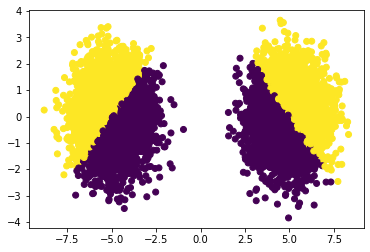

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x_g1,y_g1,c = label_g1)
plt.scatter(x_g2,y_g2,c = label_g2)

In [ ]:
X = np.concatenate([features_g1,features_g2],axis=0)
y = np.concatenate([label_g1,label_g2],axis=0)
print(X.shape)
print(y.shape)
sample_weight = np.ones_like(y)
sample_weight = sample_weight / len(sample_weight)
sample_weight_p_pos,sample_weight_p_neg,sample_weight_np_pos,sample_weight_np_neg = np.zeros_like(y),np.zeros_like(y),np.zeros_like(y),np.zeros_like(y)
sa_index = 0
sa_value = 0
print(sample_weight_p_pos.shape)

sample_weight_p_pos[np.logical_and(y==1,X[:,sa_index]>=sa_value)] = sample_weight[np.logical_and(y==1,X[:,sa_index]>=sa_value)] / sum(sample_weight[np.logical_and(y==1,X[:,sa_index]>=sa_value)])
sample_weight_p_neg[np.logical_and(y!=1,X[:,sa_index]>=sa_value)] = sample_weight[np.logical_and(y!=1,X[:,sa_index]>=sa_value)] / sum(sample_weight[np.logical_and(y!=1,X[:,sa_index]>=sa_value)])
sample_weight_np_pos[np.logical_and(y==1,X[:,sa_index]<=sa_value)] = sample_weight[np.logical_and(y==1,X[:,sa_index]<=sa_value)] / sum(sample_weight[np.logical_and(y==1,X[:,sa_index]<=sa_value)])
sample_weight_np_neg[np.logical_and(y!=1,X[:,sa_index]<=sa_value)] = sample_weight[np.logical_and(y!=1,X[:,sa_index]<=sa_value)] / sum(sample_weight[np.logical_and(y!=1,X[:,sa_index]<=sa_value)])

sample_weight = sample_weight_p_pos + sample_weight_p_neg + sample_weight_np_pos + sample_weight_np_neg
sample_weight = sample_weight/sample_weight.sum()

(10000, 2)
(10000,)
(10000,)


In [ ]:
def covert_data(features_g1,features_g2,label_g1,label_g2,num_list=[20,20,100,20]):
  X = np.concatenate([features_g1[label_g1 == 1][:num_list[0]],features_g1[label_g1 != 1][:num_list[1]],features_g2[label_g2 == 1][:num_list[2]],features_g2[label_g2 != 1][:num_list[3]]],axis=0)
  y = np.concatenate([label_g1[label_g1 == 1][:num_list[0]],label_g1[label_g1 != 1][:num_list[1]],label_g2[label_g2 == 1][:num_list[2]],label_g2[label_g2 != 1][:num_list[3]]],axis=0)
  return X,y



def draw_adaboost(X,y,n_estimators=70,use_sample_weight=True):
  from sklearn.ensemble import AdaBoostClassifier
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.model_selection import train_test_split
  from sklearn.linear_model import LogisticRegression
  
  """
  bdt = AdaBoostClassifier(
      DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=n_estimators
  )
  """

  bdt = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=n_estimators, random_state=20
  )
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=20)
  # y_train = y_train.reshape([-1,1])
  sample_weight = np.ones_like(y_train)
  sample_weight = sample_weight / len(sample_weight)
  sample_weight_p_pos,sample_weight_p_neg,sample_weight_np_pos,sample_weight_np_neg = np.zeros_like(y_train),np.zeros_like(y_train),np.zeros_like(y_train),np.zeros_like(y_train)
  sa_index = 0
  sa_value = 0

  print(X_train.shape)
  print(y_train.shape)

  # y_train = y_train.reshape([-1,1])

  sample_weight_p_pos[np.logical_and(y_train==1,X_train[:,sa_index]>=sa_value)] = sample_weight[np.logical_and(y_train==1,X_train[:,sa_index]>=sa_value)] / sum(sample_weight[np.logical_and(y_train==1,X_train[:,sa_index]>=sa_value)])
  sample_weight_p_neg[np.logical_and(y_train!=1,X_train[:,sa_index]>=sa_value)] = sample_weight[np.logical_and(y_train!=1,X_train[:,sa_index]>=sa_value)] / sum(sample_weight[np.logical_and(y_train!=1,X_train[:,sa_index]>=sa_value)])
  sample_weight_np_pos[np.logical_and(y_train==1,X_train[:,sa_index]<=sa_value)] = sample_weight[np.logical_and(y_train==1,X_train[:,sa_index]<=sa_value)] / sum(sample_weight[np.logical_and(y_train==1,X_train[:,sa_index]<=sa_value)])
  sample_weight_np_neg[np.logical_and(y_train!=1,X_train[:,sa_index]<=sa_value)] = sample_weight[np.logical_and(y_train!=1,X_train[:,sa_index]<=sa_value)] / sum(sample_weight[np.logical_and(y_train!=1,X_train[:,sa_index]<=sa_value)])

  sample_weight = sample_weight_p_pos + sample_weight_p_neg + sample_weight_np_pos + sample_weight_np_neg
  sample_weight = sample_weight/sample_weight.sum()

  if use_sample_weight == True:
    bdt.fit(X_train, y_train, sample_weight=sample_weight)
  else:
    bdt.fit(X_train, y_train)
  X_train_g1_pos = X_train[np.logical_and(y_train==1,X_train[:,sa_index]>=sa_value)]
  X_train_g1_neg = X_train[np.logical_and(y_train!=1,X_train[:,sa_index]>=sa_value)]
  X_train_g2_pos = X_train[np.logical_and(y_train==1,X_train[:,sa_index]<=sa_value)]
  X_train_g2_neg = X_train[np.logical_and(y_train!=1,X_train[:,sa_index]<=sa_value)]

  y_train_g1_pos = y_train[np.logical_and(y_train==1,X_train[:,sa_index]>=sa_value)] 
  y_train_g1_neg = y_train[np.logical_and(y_train!=1,X_train[:,sa_index]>=sa_value)] 
  y_train_g2_pos = y_train[np.logical_and(y_train==1,X_train[:,sa_index]<=sa_value)] 
  y_train_g2_neg = y_train[np.logical_and(y_train!=1,X_train[:,sa_index]<=sa_value)]


  X_test_g1_pos = X_test[np.logical_and(y_test==1,X_test[:,sa_index]>=sa_value)]
  X_test_g1_neg = X_test[np.logical_and(y_test!=1,X_test[:,sa_index]>=sa_value)]
  X_test_g2_pos = X_test[np.logical_and(y_test==1,X_test[:,sa_index]<=sa_value)]
  X_test_g2_neg = X_test[np.logical_and(y_test!=1,X_test[:,sa_index]<=sa_value)]

  y_test_g1_pos = y_test[np.logical_and(y_test==1,X_test[:,sa_index]>=sa_value)] 
  y_test_g1_neg = y_test[np.logical_and(y_test!=1,X_test[:,sa_index]>=sa_value)] 
  y_test_g2_pos = y_test[np.logical_and(y_test==1,X_test[:,sa_index]<=sa_value)] 
  y_test_g2_neg = y_test[np.logical_and(y_test!=1,X_test[:,sa_index]<=sa_value)]

  print('-----------Training-----------')
  print('g1_pos_acc',bdt.score(X_train_g1_pos,y_train_g1_pos))
  print('g1_neg_acc',bdt.score(X_train_g1_neg,y_train_g1_neg))
  print('g2_pos_acc',bdt.score(X_train_g2_pos,y_train_g2_pos))
  print('g2_neg_acc',bdt.score(X_train_g2_neg,y_train_g2_neg))

  
  print('-----------Testing-----------')
  print('g1_pos_acc',bdt.score(X_test_g1_pos,y_test_g1_pos))
  print('g1_neg_acc',bdt.score(X_test_g1_neg,y_test_g1_neg))
  print('g2_pos_acc',bdt.score(X_test_g2_pos,y_test_g2_pos))
  print('g2_neg_acc',bdt.score(X_test_g2_neg,y_test_g2_neg))


  list_tr = [bdt.score(X_train_g1_pos,y_train_g1_pos),bdt.score(X_train_g1_neg,y_train_g1_neg),bdt.score(X_train_g2_pos,y_train_g2_pos),bdt.score(X_train_g2_neg,y_train_g2_neg)]
  list_te = [bdt.score(X_test_g1_pos,y_test_g1_pos),bdt.score(X_test_g1_neg,y_test_g1_neg),bdt.score(X_test_g2_pos,y_test_g2_pos),bdt.score(X_test_g2_neg,y_test_g2_neg)]

  # DP_tr = np.abs()
  # print(y_train_g1_pos)

  plot_colors = "br"
  plot_step = 0.02
  class_names = "AB"

  plt.figure(figsize=(12, 6))

  # Plot the decision boundaries
  plt.subplot(121)
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(
      np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
  )

  Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
  plt.axis("tight")

  # Plot the training points
  for i, n, c in zip([-1,1], class_names, plot_colors):
      idx = np.where(y_train == i)
      plt.scatter(
          X_train[idx, 0],
          X_train[idx, 1],
          c=c,
          cmap=plt.cm.hsv,
          s=20,
          edgecolor="k",
          label="Train Class %s" % n,
      )
  
  for i, n, c in zip([-1,1], class_names, plot_colors):
      idx = np.where(y_test == i)
      plt.scatter(
          X_test[idx, 0],
          X_test[idx, 1],
          c=c,
          cmap=plt.cm.hsv,
          s=20,
          edgecolor="k",
          label="Test Class %s" % n,
          alpha=0.5

      )

  # plt.scatter(x_g1,y_g1,c = label_g1,cmap=plt.cm.PuBu)
  # plt.scatter(x_g2,y_g2,c = label_g2,cmap=plt.cm.PuBu)
  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)
  plt.legend(loc="upper right",fontsize=14)
  plt.xlabel("$x_{1}$",fontsize=22)
  plt.ylabel("$x_{2}$",fontsize=22)
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)

  return list_tr,list_te


def draw_gbdt(X,y,n_estimators=70):
  from sklearn.ensemble import AdaBoostClassifier
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.model_selection import train_test_split
  from sklearn.ensemble import GradientBoostingClassifier

  bdt = GradientBoostingClassifier(n_estimators=n_estimators,max_depth=1)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=20)
  bdt.fit(X_train, y_train)

  plot_colors = "br"
  plot_step = 0.02
  class_names = "AB"

  plt.figure(figsize=(12, 6))
  # Plot the decision boundaries
  plt.subplot(121)
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(
      np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
  )

  Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  cs = plt.contourf(xx, yy, Z, cmap=plt.cm.PRGn)
  plt.axis("tight")

  # Plot the training points
  for i, n, c in zip([-1,1], class_names, plot_colors):
      idx = np.where(y_train == i)
      plt.scatter(
          X_train[idx, 0],
          X_train[idx, 1],
          c=c,
          cmap=plt.cm.hsv,
          s=20,
          edgecolor="k",
          label="Train Class %s" % n,
      )
  
  for i, n, c in zip([-1,1], class_names, plot_colors):
      idx = np.where(y_test == i)
      plt.scatter(
          X_test[idx, 0],
          X_test[idx, 1],
          c=c,
          cmap=plt.cm.hsv,
          s=20,
          edgecolor="k",
          label="Test Class %s" % n,
          alpha=0.1

      )

  # plt.scatter(x_g1,y_g1,c = label_g1,cmap=plt.cm.PuBu)
  # plt.scatter(x_g2,y_g2,c = label_g2,cmap=plt.cm.PuBu)

  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)
  plt.legend(loc="upper right")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.title("Decision Boundary")  

In [ ]:
def draw_adaboost_group_2(X,y,n_estimators=70,fair_constrain=0.2):
  from sklearn.ensemble import AdaBoostClassifier
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.model_selection import train_test_split

  bdt = Group_AdaBoost(
      DecisionTreeClassifier(max_depth=1), n_estimators=n_estimators,saIndex=0,saValue=0,adaptive_beta=False,calibrate_base_learner_beta=False,fair_constrain=fair_constrain,random_state=10)
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=20)
  bdt.fit(X_train, y_train)


  X_train_g1_pos = X_train[np.logical_and(y_train==1,X_train[:,sa_index]>=sa_value)]
  X_train_g1_neg = X_train[np.logical_and(y_train!=1,X_train[:,sa_index]>=sa_value)]
  X_train_g2_pos = X_train[np.logical_and(y_train==1,X_train[:,sa_index]<=sa_value)]
  X_train_g2_neg = X_train[np.logical_and(y_train!=1,X_train[:,sa_index]<=sa_value)]

  y_train_g1_pos = y_train[np.logical_and(y_train==1,X_train[:,sa_index]>=sa_value)] 
  y_train_g1_neg = y_train[np.logical_and(y_train!=1,X_train[:,sa_index]>=sa_value)] 
  y_train_g2_pos = y_train[np.logical_and(y_train==1,X_train[:,sa_index]<=sa_value)] 
  y_train_g2_neg = y_train[np.logical_and(y_train!=1,X_train[:,sa_index]<=sa_value)]


  X_test_g1_pos = X_test[np.logical_and(y_test==1,X_test[:,sa_index]>=sa_value)]
  X_test_g1_neg = X_test[np.logical_and(y_test!=1,X_test[:,sa_index]>=sa_value)]
  X_test_g2_pos = X_test[np.logical_and(y_test==1,X_test[:,sa_index]<=sa_value)]
  X_test_g2_neg = X_test[np.logical_and(y_test!=1,X_test[:,sa_index]<=sa_value)]

  y_test_g1_pos = y_test[np.logical_and(y_test==1,X_test[:,sa_index]>=sa_value)] 
  y_test_g1_neg = y_test[np.logical_and(y_test!=1,X_test[:,sa_index]>=sa_value)] 
  y_test_g2_pos = y_test[np.logical_and(y_test==1,X_test[:,sa_index]<=sa_value)] 
  y_test_g2_neg = y_test[np.logical_and(y_test!=1,X_test[:,sa_index]<=sa_value)]

  print('-----------Training-----------')
  print('g1_pos_acc',bdt.score(X_train_g1_pos,y_train_g1_pos))
  print('g1_neg_acc',bdt.score(X_train_g1_neg,y_train_g1_neg))
  print('g2_pos_acc',bdt.score(X_train_g2_pos,y_train_g2_pos))
  print('g2_neg_acc',bdt.score(X_train_g2_neg,y_train_g2_neg))

  
  print('-----------Testing-----------')
  print('g1_pos_acc',bdt.score(X_test_g1_pos,y_test_g1_pos))
  print('g1_neg_acc',bdt.score(X_test_g1_neg,y_test_g1_neg))
  print('g2_pos_acc',bdt.score(X_test_g2_pos,y_test_g2_pos))
  print('g2_neg_acc',bdt.score(X_test_g2_neg,y_test_g2_neg))

  list_tr = [bdt.score(X_train_g1_pos,y_train_g1_pos),bdt.score(X_train_g1_neg,y_train_g1_neg),bdt.score(X_train_g2_pos,y_train_g2_pos),bdt.score(X_train_g2_neg,y_train_g2_neg)]
  list_te = [bdt.score(X_test_g1_pos,y_test_g1_pos),bdt.score(X_test_g1_neg,y_test_g1_neg),bdt.score(X_test_g2_pos,y_test_g2_pos),bdt.score(X_test_g2_neg,y_test_g2_neg)]


  plot_colors = "br"
  # plot_colors = ['green','black']
  plot_step = 0.02
  class_names = "AB"

  plt.figure(figsize=(12, 6))
  # Plot the decision boundaries
  plt.subplot(121)
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(
      np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
  )

  Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
  plt.axis("tight")

  # Plot the training points
  for i, n, c in zip([-1,1], class_names, plot_colors):
      idx = np.where(y_train == i)
      plt.scatter(
          X_train[idx, 0],
          X_train[idx, 1],
          c=c,
          cmap=plt.cm.hsv,
          s=20,
          edgecolor="k",
          label="Train Class %s" % n,
      )
  
  for i, n, c in zip([-1,1], class_names, plot_colors):
      idx = np.where(y_test == i)
      plt.scatter(
          X_test[idx, 0],
          X_test[idx, 1],
          c=c,
          cmap=plt.cm.hsv,
          s=20,
          edgecolor="k",
          label="Test Class %s" % n,
          alpha=0.5

      )

  # plt.scatter(x_g1,y_g1,c = label_g1,cmap=plt.cm.PuBu)
  # plt.scatter(x_g2,y_g2,c = label_g2,cmap=plt.cm.PuBu)

  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)
  plt.legend(loc="upper right",fontsize=14)
  plt.xlabel("$x_{1}$",fontsize=22)
  plt.ylabel("$x_{2}$",fontsize=22)
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)
  # plt.title("Decision Boundary")

  return list_tr,list_te

In [ ]:
def draw_model(X,y,model,n_estimators=70,use_sample_weight=True):
  from sklearn.ensemble import AdaBoostClassifier
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.model_selection import train_test_split
  from sklearn.linear_model import LogisticRegression
  
  """
  bdt = AdaBoostClassifier(
      DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=n_estimators
  )
  """

  bdt = model
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=20)
  # y_train = y_train.reshape([-1,1])
  sample_weight = np.ones_like(y_train)
  sample_weight = sample_weight / len(sample_weight)
  sample_weight_p_pos,sample_weight_p_neg,sample_weight_np_pos,sample_weight_np_neg = np.zeros_like(y_train),np.zeros_like(y_train),np.zeros_like(y_train),np.zeros_like(y_train)
  sa_index = 0
  sa_value = 0

  print(X_train.shape)
  print(y_train.shape)

  # y_train = y_train.reshape([-1,1])

  sample_weight_p_pos[np.logical_and(y_train==1,X_train[:,sa_index]>=sa_value)] = sample_weight[np.logical_and(y_train==1,X_train[:,sa_index]>=sa_value)] / sum(sample_weight[np.logical_and(y_train==1,X_train[:,sa_index]>=sa_value)])
  sample_weight_p_neg[np.logical_and(y_train!=1,X_train[:,sa_index]>=sa_value)] = sample_weight[np.logical_and(y_train!=1,X_train[:,sa_index]>=sa_value)] / sum(sample_weight[np.logical_and(y_train!=1,X_train[:,sa_index]>=sa_value)])
  sample_weight_np_pos[np.logical_and(y_train==1,X_train[:,sa_index]<=sa_value)] = sample_weight[np.logical_and(y_train==1,X_train[:,sa_index]<=sa_value)] / sum(sample_weight[np.logical_and(y_train==1,X_train[:,sa_index]<=sa_value)])
  sample_weight_np_neg[np.logical_and(y_train!=1,X_train[:,sa_index]<=sa_value)] = sample_weight[np.logical_and(y_train!=1,X_train[:,sa_index]<=sa_value)] / sum(sample_weight[np.logical_and(y_train!=1,X_train[:,sa_index]<=sa_value)])

  sample_weight = sample_weight_p_pos + sample_weight_p_neg + sample_weight_np_pos + sample_weight_np_neg
  sample_weight = sample_weight/sample_weight.sum()

  if use_sample_weight == True:
    bdt.fit(X_train, y_train, sample_weight=sample_weight)
  else:
    bdt.fit(X_train, y_train)
  X_train_g1_pos = X_train[np.logical_and(y_train==1,X_train[:,sa_index]>=sa_value)]
  X_train_g1_neg = X_train[np.logical_and(y_train!=1,X_train[:,sa_index]>=sa_value)]
  X_train_g2_pos = X_train[np.logical_and(y_train==1,X_train[:,sa_index]<=sa_value)]
  X_train_g2_neg = X_train[np.logical_and(y_train!=1,X_train[:,sa_index]<=sa_value)]

  y_train_g1_pos = y_train[np.logical_and(y_train==1,X_train[:,sa_index]>=sa_value)] 
  y_train_g1_neg = y_train[np.logical_and(y_train!=1,X_train[:,sa_index]>=sa_value)] 
  y_train_g2_pos = y_train[np.logical_and(y_train==1,X_train[:,sa_index]<=sa_value)] 
  y_train_g2_neg = y_train[np.logical_and(y_train!=1,X_train[:,sa_index]<=sa_value)]


  X_test_g1_pos = X_test[np.logical_and(y_test==1,X_test[:,sa_index]>=sa_value)]
  X_test_g1_neg = X_test[np.logical_and(y_test!=1,X_test[:,sa_index]>=sa_value)]
  X_test_g2_pos = X_test[np.logical_and(y_test==1,X_test[:,sa_index]<=sa_value)]
  X_test_g2_neg = X_test[np.logical_and(y_test!=1,X_test[:,sa_index]<=sa_value)]

  y_test_g1_pos = y_test[np.logical_and(y_test==1,X_test[:,sa_index]>=sa_value)] 
  y_test_g1_neg = y_test[np.logical_and(y_test!=1,X_test[:,sa_index]>=sa_value)] 
  y_test_g2_pos = y_test[np.logical_and(y_test==1,X_test[:,sa_index]<=sa_value)] 
  y_test_g2_neg = y_test[np.logical_and(y_test!=1,X_test[:,sa_index]<=sa_value)]

  print('-----------Training-----------')
  print('g1_pos_acc',bdt.score(X_train_g1_pos,y_train_g1_pos))
  print('g1_neg_acc',bdt.score(X_train_g1_neg,y_train_g1_neg))
  print('g2_pos_acc',bdt.score(X_train_g2_pos,y_train_g2_pos))
  print('g2_neg_acc',bdt.score(X_train_g2_neg,y_train_g2_neg))

  
  print('-----------Testing-----------')
  print('g1_pos_acc',bdt.score(X_test_g1_pos,y_test_g1_pos))
  print('g1_neg_acc',bdt.score(X_test_g1_neg,y_test_g1_neg))
  print('g2_pos_acc',bdt.score(X_test_g2_pos,y_test_g2_pos))
  print('g2_neg_acc',bdt.score(X_test_g2_neg,y_test_g2_neg))


  plot_colors = "br"
  plot_step = 0.02
  class_names = "AB"

  plt.figure(figsize=(20, 10))

  # Plot the decision boundaries
  plt.subplot(121)
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(
      np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
  )

  Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  cs = plt.contourf(xx, yy, Z, cmap=plt.cm.hsv)
  plt.axis("tight")

  # Plot the training points
  for i, n, c in zip([-1,1], class_names, plot_colors):
      idx = np.where(y_train == i)
      plt.scatter(
          X_train[idx, 0],
          X_train[idx, 1],
          c=c,
          cmap=plt.cm.hsv,
          s=20,
          edgecolor="k",
          label="Train Class %s" % n,
      )
  
  for i, n, c in zip([-1,1], class_names, plot_colors):
      idx = np.where(y_test == i)
      plt.scatter(
          X_test[idx, 0],
          X_test[idx, 1],
          c=c,
          cmap=plt.cm.hsv,
          s=20,
          edgecolor="k",
          label="Test Class %s" % n,
          alpha=0.1

      )

  # plt.scatter(x_g1,y_g1,c = label_g1,cmap=plt.cm.PuBu)
  # plt.scatter(x_g2,y_g2,c = label_g2,cmap=plt.cm.PuBu)

  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)
  plt.legend(loc="upper right")
  plt.xlabel("$x_{1}$")
  plt.ylabel("$x_{2}$")
  plt.title("Decision Boundary")


AdaBoost
(1300, 2)
(1300,)
-----------Training-----------
g1_pos_acc 1.0
g1_neg_acc 0.5643564356435643
g2_pos_acc 0.8058252427184466
g2_neg_acc 0.76
-----------Testing-----------
g1_pos_acc 1.0
g1_neg_acc 0.40404040404040403
g2_pos_acc 0.7938144329896907
g2_neg_acc 0.72
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

Text(0.5, 1.0, 'Ours(with $\\epsilon$)')

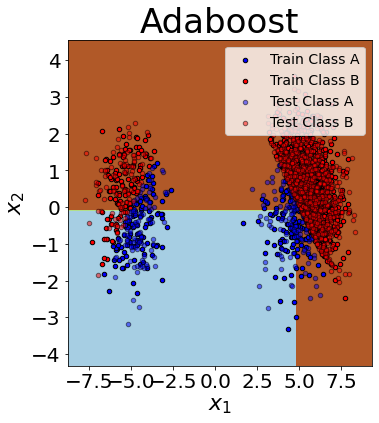

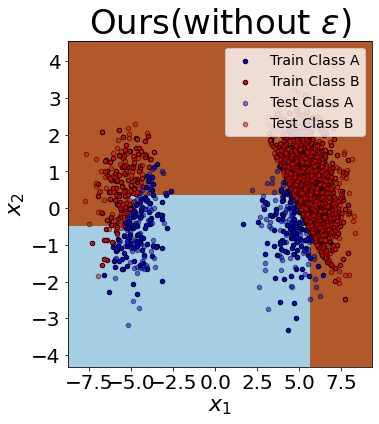

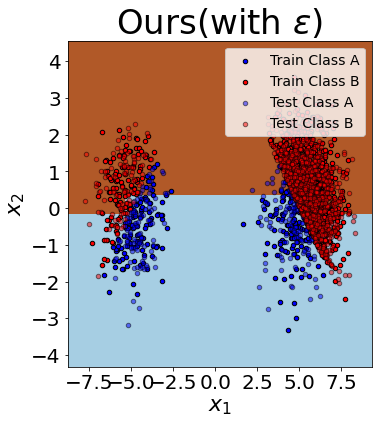

In [ ]:
X,y = covert_data(features_g1,features_g2,label_g1,label_g2,num_list=[200,200,2000,200])

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

# draw_model(X,y,DecisionTreeClassifier(max_depth=3),use_sample_weight=True)

print('AdaBoost')
list_tr_ada,list_te_ada = draw_adaboost(X,y,use_sample_weight=False,n_estimators=10)
plt.title('Adaboost', fontsize=34)
print('\n')
print('Ours')
list_tr_our,list_te_our = draw_adaboost(X,y,use_sample_weight=True,n_estimators=10)
plt.title('Ours(without $\epsilon$)', fontsize=34)
# draw_gbdt(X,y)
list_tr_our_2,list_te_our_2 = draw_adaboost_group_2(X,y,n_estimators=10,fair_constrain=0.2)
plt.title('Ours(with $\epsilon$)', fontsize=34)

                          $\Delta_{EO}$ Train  ...  $\zeta_{gb}$ Test
Adaboost                             0.510134  ...           0.729464
Ours(without $\epsilon$)             0.139732  ...           0.856290
Ours(with $\epsilon$)                0.037329  ...           0.805714

[3 rows x 4 columns]


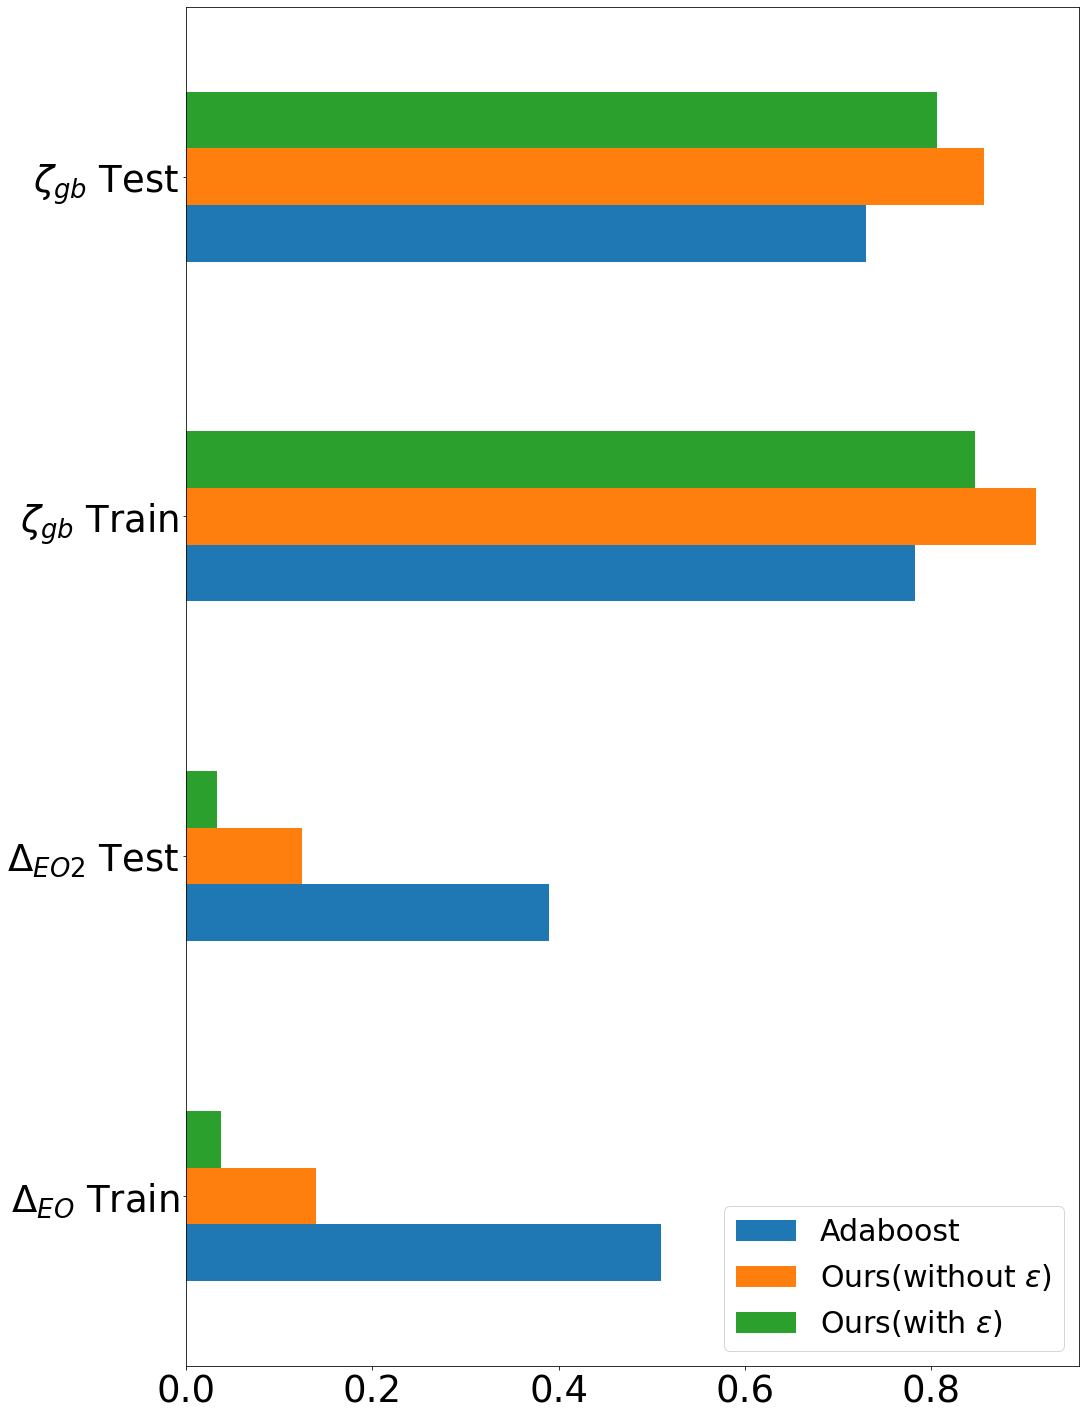

In [ ]:
import pandas as pd
def draw_metrics(list_tr_lst,list_te_lst,name_lst):
  data = pd.DataFrame(columns=['$\Delta_{EO}$ Train', '$\Delta_{EO2}$ Test', '$\zeta_{gb}$ Train','$\zeta_{gb}$ Test'])
  for i in range(len(list_tr_lst)):
    name = name_lst[i]
    list_tr,list_te = list_tr_lst[i],list_te_lst[i]
    Group_Bal_Acc_tr = sum(list_tr) / 4
    Eq_Od_tr = abs(list_tr[2]-list_tr[0]) + abs(list_tr[3]-list_tr[1])


    Group_Bal_Acc_te = sum(list_te) / 4
    Eq_Od_te = abs(list_tr[2]-list_te[0]) + abs(list_te[3]-list_te[1])

    res_list = [Eq_Od_tr, Eq_Od_te, Group_Bal_Acc_tr,Group_Bal_Acc_te,name]
    # name_list = ['Eq_Od_tr', 'Eq_Od_te', 'G_B_Acc_tr','G_B_Acc_te','Name']
    # res = {'Eq_Od_tr':Eq_Od_tr, 'Eq_Od_te':Eq_Od_te, 'G_B_Acc_tr':Group_Bal_Acc_tr,'G_B_Acc_te':Group_Bal_Acc_te,'Name':name}
    name_list = ['$\Delta_{EO}$ Train', 'Eq_Od_te', 'G_B_Acc_tr','G_B_Acc_te']
    res = {'$\Delta_{EO}$ Train':Eq_Od_te, '$\Delta_{EO2}$ Test':Eq_Od_tr, '$\zeta_{gb}$ Train':Group_Bal_Acc_tr,'$\zeta_{gb}$ Test':Group_Bal_Acc_te}
    

    data.loc[name] = res  
  print(data)
  data = data.T
  data.plot(kind='barh',figsize=[16,25],fontsize=37)
  plt.legend(fontsize=30)
  # seaborn.barplot(data=data,y='Name',x='Eq_Od_tr',orient='h',palette="flare")
  # seaborn.set(font_scale = 2)
  # plt.xlim(0,1)

draw_metrics([list_tr_ada,list_tr_our,list_tr_our_2],[list_te_ada,list_te_our,list_te_our_2],['Adaboost','Ours(without $\epsilon$)','Ours(with $\epsilon$)'])


In [ ]:
draw_metrics([list_tr_our_2],[list_te_our_2])

In [ ]:
def draw_metrics(list_tr,list_te):
  Group_Bal_Acc_tr = sum(list_tr)
  Eq_Od_tr = abs(list_tr[2]-list_tr[0]) + abs(list_tr[3]-list_tr[1])
  Group_Cor_tr = [abs(i-sum(list_tr)/4) for i in list_tr]
  Group_Cor_tr = sum(Group_Cor_tr)

  Group_Bal_Acc_te = sum(list_te)
  Eq_Od_te = abs(list_tr[2]-list_te[0]) + abs(list_te[3]-list_te[1])
  Group_Cor_te = [abs(i-sum(list_te)/4) for i in list_te]
  Group_Cor_te = sum(Group_Cor_te)

  res_list = [Group_Bal_Acc_tr, Eq_Od_tr, Group_Cor_tr, Group_Bal_Acc_te, Eq_Od_te, Group_Cor_te]
  name_list =  ['Group Bal Acc Train', 'Eq Od Train', 'Group Cor train', 'Group Bal Acc Test', 'Eq Od Test', 'Group Cor Test']

  seaborn.barplot(y=name_list,x=res_list,orient='h',palette="flare")
draw_metrics(list_tr,list_te)